# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**

## Data Validation
The original dataset had 947 records/rows and 8 variables/columns. I performed validation for all variables to bring the dataset in line with the description in the "Data Information" section of the instructions. During validation, I added 1 new variable (indicated with **"*"** below), bringing the total to 10 variables:
- `recipe`: 947 unique numeric indices indentifying each recipe. No cleaning required.
- `calories`: numeric value indicating number of calories in each recipe. A few very high values. 52 missing/NA values. No cleaning required.
- `carbohydrate`: numeric value indicating grams of carbohydrates in each recipe. A few very high values. 52 missing/NA values. No cleaning required.
- `sugar`: numeric value indicating grams of sugar in each recipe. A few very high values. 52 missing/NA values. No cleaning required.
- `protein`: numeric value indicating grams of protein in each recipe. A few very high values. 52 missing/NA values. No cleaning required. 
- `category`: Consolidated all chicken recipes into "Chicken" category, resulting in 10 categories total. No missing/NA values. Converted from character string to factor.
- `servings`: 4 unique, numeric values indicating number of servings for each recipe. No missing/NA values. Original data had numbers stored as strings, some also with characters; removed all character strings and converted to numeric. 
- `high_traffic`: Original dataset had 574 recipes labeled as "High" traffic with  all other recipes having NA values (i.e., no data). For ease of calculation, converted to logical type: "High" --> TRUE; NA --> FALSE.
- *`missing`: logical indicating whether `calories`/`carbohydrate`/`sugar`/`protein` had missing values. Confirmed that values were missing from the same 52 recipes across all four variables. 52 TRUE values. Added during validation.

Load packages and dataset...

In [33]:
### load libraries & import dataset
library(dplyr)
library(ggplot2)
library(xgboost)
library(caret)
library(pROC)
library(lme4)

dfr <- read.csv("recipe_site_traffic_2212.csv")

### Dataset Overview
Checking general structure as well as counting NA/missing values.

In [34]:
### CHECK structure & NA values

str(dfr)
#'data.frame':	947 obs. of  8 variables:
# $ recipe      : int  1 2 3 4 5 6 7 8 9 10 ... --> OK (numeric)
# $ calories    : num  NA 35.5 914.3 97 27.1 ... --> OK (numeric)
# $ carbohydrate: num  NA 38.56 42.68 30.56 1.85 ... --> OK (numeric)
# $ sugar       : num  NA 0.66 3.09 38.63 0.8 ... --> OK (numeric)
# $ protein     : num  NA 0.92 2.88 0.02 0.53 ... --> OK (numeric)
# $ category    : chr  "Pork" "Potato" "Breakfast" "Beverages" ... --> CONVERT TO FACTOR
# $ servings    : chr  "6" "4" "1" "4" ... --> CONVERT TO NUMERIC
# $ high_traffic: chr  "High" "High" NA "High" ... --> CONVERT TO LOGICAL

print(sapply(dfr, function(x){sum(is.na(x))}))
#      recipe     calories carbohydrate        sugar      protein     category 
#           0           52           52           52           52            0 
#    servings high_traffic 
#           0          373 


'data.frame':	947 obs. of  8 variables:
 $ recipe      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ calories    : num  NA 35.5 914.3 97 27.1 ...
 $ carbohydrate: num  NA 38.56 42.68 30.56 1.85 ...
 $ sugar       : num  NA 0.66 3.09 38.63 0.8 ...
 $ protein     : num  NA 0.92 2.88 0.02 0.53 ...
 $ category    : chr  "Pork" "Potato" "Breakfast" "Beverages" ...
 $ servings    : chr  "6" "4" "1" "4" ...
 $ high_traffic: chr  "High" "High" NA "High" ...
      recipe     calories carbohydrate        sugar      protein     category 
           0           52           52           52           52            0 
    servings high_traffic 
           0          373 


### \$recipe variable
All values are unique.

In [35]:
### VALIDATE $recipe: "Numeric, unique identifier of recipe"
# already numeric (integer)
if(length(dfr$recipe) == length(unique(dfr$recipe))){
	print("All recipe identifiers unique")
} else {print("All recipe identifiers NOT unique")}

#plot(dfr$recipe) # check range of values --> OK

[1] "All recipe identifiers unique"


### \$calories, \$carbohydrate, \$sugar, \$protein (nutritional variables)
Visualizing distribution with histograms.

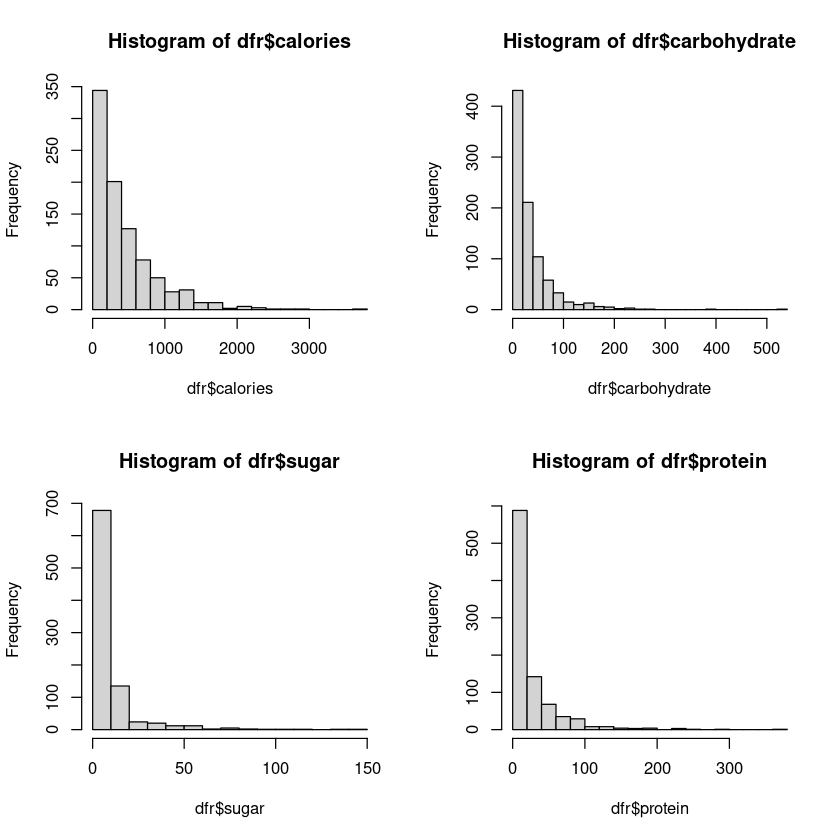

In [36]:
### VALIDATE & explore $calories, $carbohydrate, $sugar, $protein (already numeric)

par(mfrow=c(2,2))
hist(dfr$calories, breaks=20) # a few really high vals
hist(dfr$carbohydrate, breaks=20) # few really high vals
hist(dfr$sugar, breaks=20) # a few really high vals
hist(dfr$protein, breaks=20) # few really high vals

The same 52 recipes are missing data for `calories`/`carbohydrate`/`sugar`/`protein`:

In [37]:
### EXPLORE overlap of 52 NA values in $calories, $carbohydrate, $sugar, $protein

# create new dataframe containing only columns with concerning NA values
dfr.na <- dfr[,c("calories", "carbohydrate", "sugar", "protein")]
#head(dfr.na)

# compile indices of NA values
na.indices <- list() # initialize empty list
for(name in names(dfr.na)){
   na.indices[[name]] <- which(is.na(dfr.na[,name]))
} # end for() loop
#na.indices

# check for equivalence across all NA indices 
# if all values TRUE, then NA values completely overlap
for(i in 2:length(na.indices)){
   print(all(na.indices[[i]] == na.indices[[i - 1]]))
} # end for() loop
# all values TRUE, so NA values in same 52 recipes


# create a new variable to flag missing values
dfr <- dfr %>% 
       mutate(missing = case_when(is.na(calories) ~ TRUE, TRUE ~ FALSE))

# check
#str(dfr)

[1] TRUE
[1] TRUE
[1] TRUE


### \$category variable
Consolidated "Chicken Breast" category into "Chicken" category to match the description of the `category` variable from the "Data Information" section of the instructions. Converted to factor class for use downstream.  

In [38]:
### VALIDATE $category

unique(dfr$category) # need to consolidate all chicken into single category

# replace "Chicken Breast" with "Chicken"
dfr$category[dfr$category == "Chicken Breast"] <- "Chicken"

unique(dfr$category) # categories now correct

dfr$category <- as.factor(dfr$category) # convert to a factor

unique(dfr$category) # confirm factor levels --> OK

[1] "Pork"           "Potato"         "Breakfast"      "Beverages"     
 [5] "One Dish Meal"  "Chicken Breast" "Lunch/Snacks"   "Chicken"       
 [9] "Vegetable"      "Meat"           "Dessert"

[1] "Pork"          "Potato"        "Breakfast"     "Beverages"    
 [5] "One Dish Meal" "Chicken"       "Lunch/Snacks"  "Vegetable"    
 [9] "Meat"          "Dessert"

[1] Pork          Potato        Breakfast     Beverages     One Dish Meal
 [6] Chicken       Lunch/Snacks  Vegetable     Meat          Dessert      
10 Levels: Beverages Breakfast Chicken Dessert Lunch/Snacks ... Vegetable

### \$servings variable
Removed text and converted to numeric class.

In [39]:
# VALIDATE $servings (NEED TO CONVERT TO NUMERIC)

unique(dfr$servings) # some records have character strings --> need to remove

# remove character strings and re-check
dfr$servings <- gsub(" as a snack", "", dfr$servings)
unique(dfr$servings)

# convert to numeric and re-check
dfr$servings <- as.numeric(dfr$servings)
unique(dfr$servings)

[1] "6"            "4"            "1"            "2"            "4 as a snack"
[6] "6 as a snack"

[1] "6" "4" "1" "2"

[1] 6 4 1 2

### \$high_traffic variable
Converted to logical type.

In [40]:
### VALIDATE $high_traffic

unique(dfr$high_traffic) # only NA & 'High'

sum(!is.na(dfr$high_traffic)) # 574 non-NA values
sum(dfr$high_traffic == "High", na.rm=TRUE) # 574 "High" values
sum(is.na(dfr$high_traffic)) # 373 NA values

# change to logical
dfr <- dfr %>% mutate(high_traffic = case_when(high_traffic == "High" ~ TRUE, TRUE ~ FALSE))

# check new values
unique(dfr$high_traffic)

[1] "High" NA

[1] 574

[1] 574

[1] 373

[1]  TRUE FALSE

### re-check variable classes
Just to be sure.

In [41]:
### VALIDATION: re-check class for ALL variables
print(sapply(dfr, class)) # all OK

      recipe     calories carbohydrate        sugar      protein     category 
   "integer"    "numeric"    "numeric"    "numeric"    "numeric"     "factor" 
    servings high_traffic      missing 
   "numeric"    "logical"    "logical" 


## Exploratory Analysis

SUMMARY

The _target variable_ is the binary variable `traffic_level`.

The _numeric predictor variables_ `servings` appears relatively uninformative with respect to `traffic_level`, but is still OK to use for modeling. 

The _numeric predictor variables_ `calories`, `carbohydrate`, `sugar`, and `protein` are problematic. Taken collectively, these variables all contain numerous values that are not physically possible. Therefore, I excluded them for modeling. 

Recipe counts seem fairly well distributed among the 10 categories in the _categorical predictor variable_ `category`. This appears to be the most informative predictor with respect to the target.

### Target variable: \$high_traffic
The variable that we are trying to predict is `high_traffic`. As mentioned the _Data Validation_ section above, 574 recipes are flagged TRUE, and the remaining 373 recipes FALSE.

### Predictor variable: $category
The `category` variable contains 10 categories. There are 172 recipes in the "Chicken" category, and between 71 and 106 recipes in each of the other nine categories.

In [42]:
# contingency table: counts for each category
tbl <- table(dfr$category) %>% sort(decreasing = TRUE)
print(tbl)


      Chicken     Breakfast     Beverages  Lunch/Snacks        Potato 
          172           106            92            89            88 
         Pork       Dessert     Vegetable          Meat One Dish Meal 
           84            83            83            79            71 


Certain recipe categories (e.g., vegetable, potato, and pork) contain disproportionately high numbers of popular recipes. This is promising for modeling.

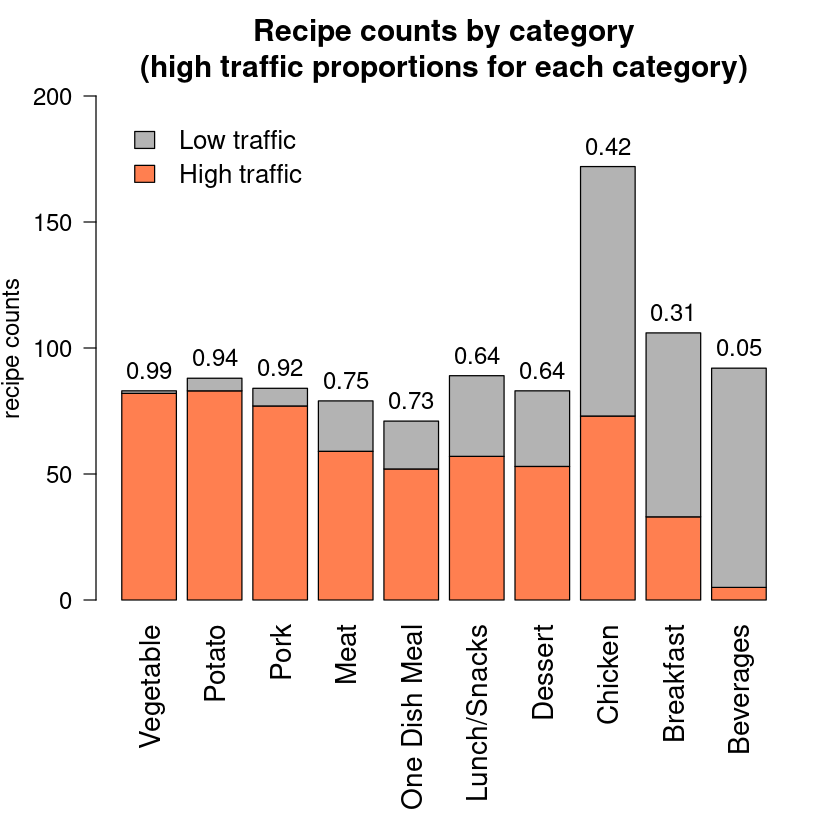

In [43]:
# contingency table: category x traffic level
out <- table(dfr$category
		   , case_when(dfr$high_traffic == 0 ~ "low traffic", TRUE ~ "high traffic"))
out <- out[order(out[,1]/(out[,1] + out[,2]), decreasing=TRUE),]
#out

#pop_by_cat <- aggregate(dfr$high_traffic, by=list(category = dfr$category), FUN=mean) %>% 
#      arrange(desc(x)) %>% rename(proportion_high_traffic=x)

pop_by_cat <- dfr %>% group_by(category) %>%  
              summarise(n_total = n(), proportion_high_traffic = mean(high_traffic)) %>%
              arrange(desc(proportion_high_traffic))
#pop_by_cat

# barplot of category counts
pop_cols <- c("coral", "grey70")
par(mar=c(10, 4, 4, 2))
bar_out <- barplot(t(out), main = "Recipe counts by category\n(high traffic proportions for each category)"
      , las=2, ylab="recipe counts", axes=TRUE,
	  , ylim=c(0, 200), cex.names=1.4, cex.lab=1.2, cex.axis=1.2
	  , col = pop_cols, cex.main=1.5)
text(x=bar_out, y=pop_by_cat$n_total, pos=3, cex=1.2
   , labels=round(pop_by_cat$proportion_high_traffic, 2))

legend("topleft", inset = 0.02,
       legend = c("Low traffic", "High traffic"),
       fill   = rev(pop_cols), bty = "n", cex=1.3)


### Predictor variables: numeric

SUMMARY 

This section explores the nature of the numeric predictor variables `calories`, `carbohydrate`, `sugar`, `protein`, and `servings`.

In the end, `servings` was the only of these variables to be carried forward for model training. 

The other four variables were deemed to be unreliable due to containing physically impossible values. Prior to making this determination, I also explored the nature of the missing values in these variables. But in the end, their unreliability due to physical impossibility superceded any considerations of missingness.

#### Missing data
As stated earlier, 52 records are entirely missing data for `calories`, `carbohydrate`, `sugar`, and `protein`. This represents about 5.5% of total records.

Using the following logic, I determined that it is not safe to delete these records, because the data do not appear to be missing completely at random (MCAR) with respect to `high_traffic`: 
- To determine if there is a statistically significant difference between proportion of missing samples with high traffic vs. low traffic, I ran a chi-squared test without continuity correction on the contingency table of `missing` x `high_traffic`.
- Chi-squared results: p = 0.03, _X_ <sup>2</sup> = 4.77, df = 1, indicating a significant difference at alpha = 0.05.
- The risk-ratio was RR = 1.9 (95% CI [1.06, 3.60]), meaning that the high traffic recipes were about twice as likely to be missing data relative to the low traffic recipes.
- Because this difference is unlikely due to chance (p < 0.05), there is a low probability that the data are Missing Completely At Random (MCAR).

In [44]:
### Explore relationship between missingness and traffic level

# Chi-squared test: Is missingness related to traffic level?
ct_mis_tfc <- table(case_when(dfr$missing == 0 ~ "not missing",dfr$missing == 1 ~ "missing")
				  , case_when(dfr$high_traffic == 0 ~ "low tr.", TRUE ~ "high tr."))
ct_mis_tfc
chi_mis_tfc <- chisq.test(ct_mis_tfc, correct=FALSE)
chi_mis_tfc
#chi_mis_tfc$expected # all > 10, so omit Yates continuity correction

# Risk ratio calculation function
risk_ratio <- function(tab, conf.level = 0.95){
  a <- tab[1,1]; b <- tab[2,1]; c <- tab[1,2]; d <- tab[2,2]
  rr <- (a/(a+b)) / (c/(c+d))
  z  <- qnorm((1+conf.level)/2)
  se <- sqrt(1/a - 1/(a+b) + 1/c - 1/(c+d))
  ci <- exp(log(rr) + c(-z, z)*se)
  list(RR = rr, CI = ci)
}

risk_ratio(ct_mis_tfc)


             
              high tr. low tr.
  missing           39      13
  not missing      535     360


	Pearson's Chi-squared test

data:  ct_mis_tfc
X-squared = 4.7707, df = 1, p-value = 0.02895


$RR
[1] 1.949477

$CI
[1] 1.055014 3.602285

#### Histograms
So far, the following five numerical variables have potential to be used as predictor variables: `calories`, `carbohydrate`, `sugar`, `protein`, `servings`.

Histograms show that `calories`, `carbohydrate`, `sugar`, and `protein` have a heavy right tails; they appear to follow exponential distributions. Histograms of the log-transforms of these variables are much closer to normal. Although classifcations models such as logistic regression and tree models do not assume predictor variables are normally distributed, log transformation stabilizes variance, reduces skew, and makes pariwise correlation more informative.

Furthermore, because `protein` cotains some 0 values and the other three variables have values close to 0, I chose to perform ln(x + 1) transforms on ALL FOUR of the variables (i.e., `calories`, `carbohydrate`, `sugar`, and `protein`), for simplicity.

On the other hand, `servings` appears to be more or less normally distributed. Log formation does not improve the distribution. So, I left this variable untransformed.

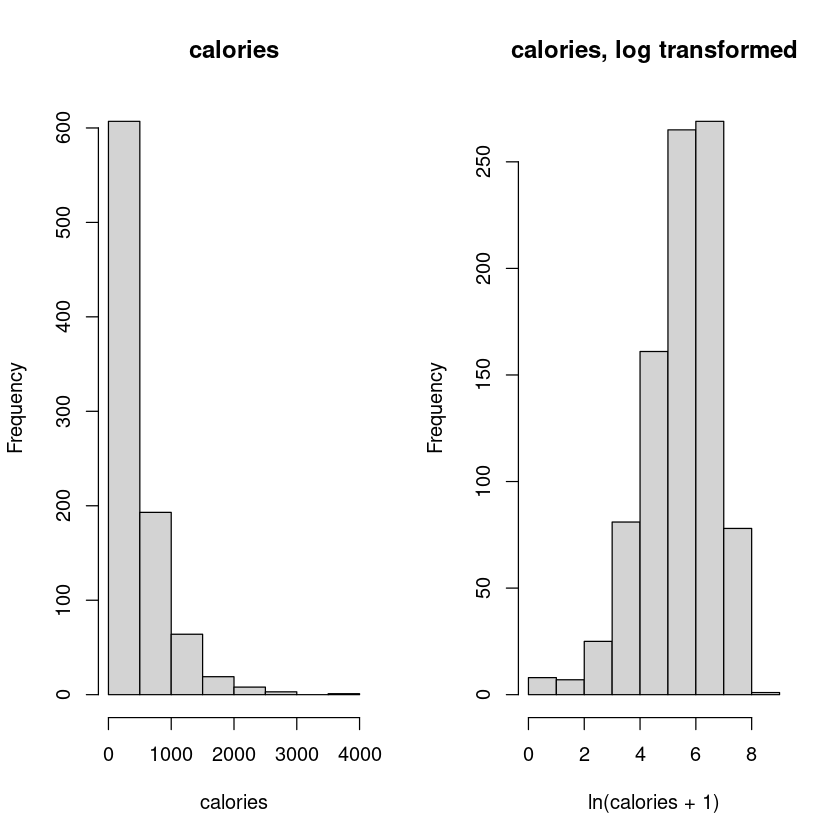

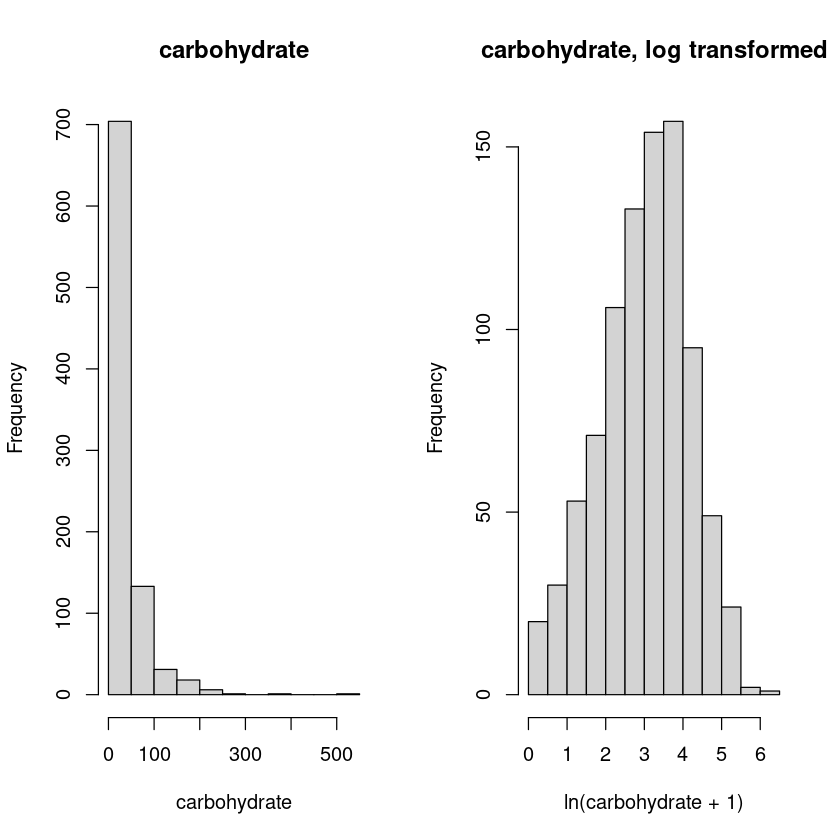

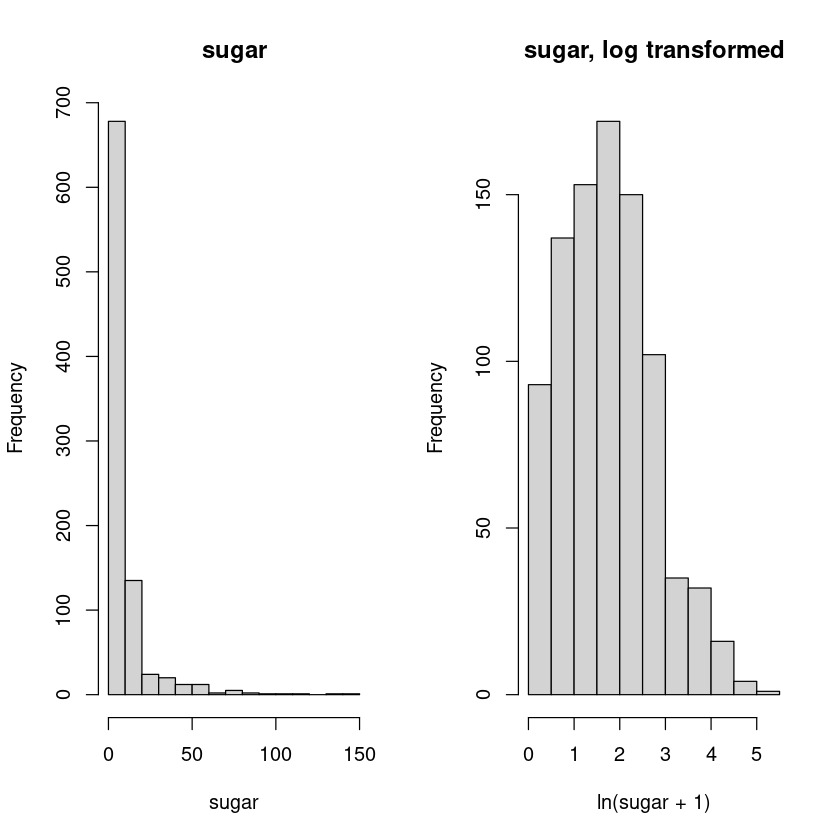

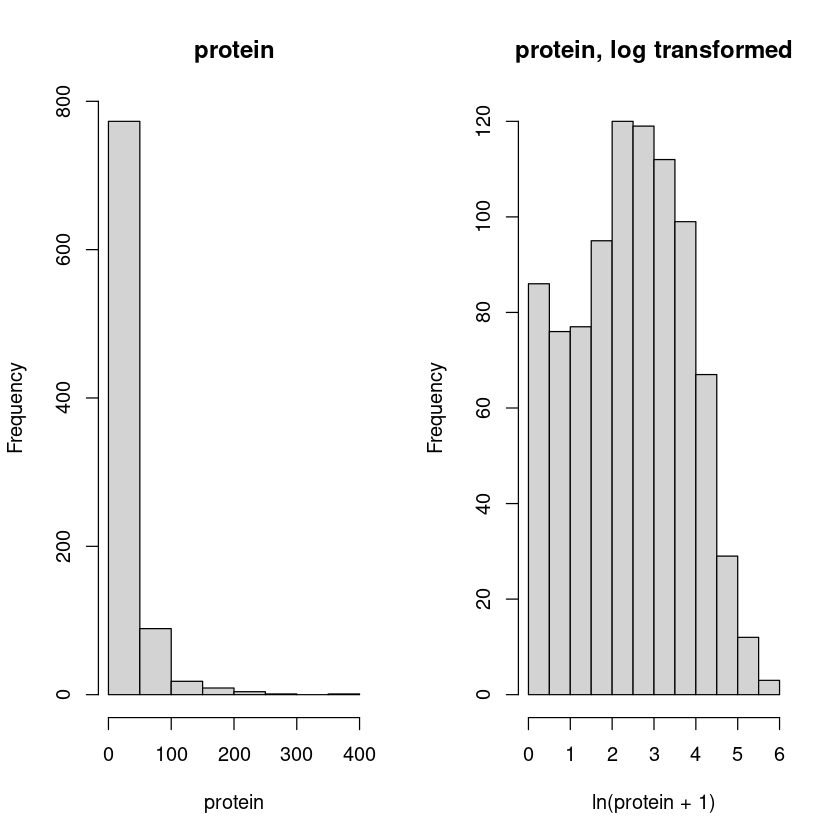

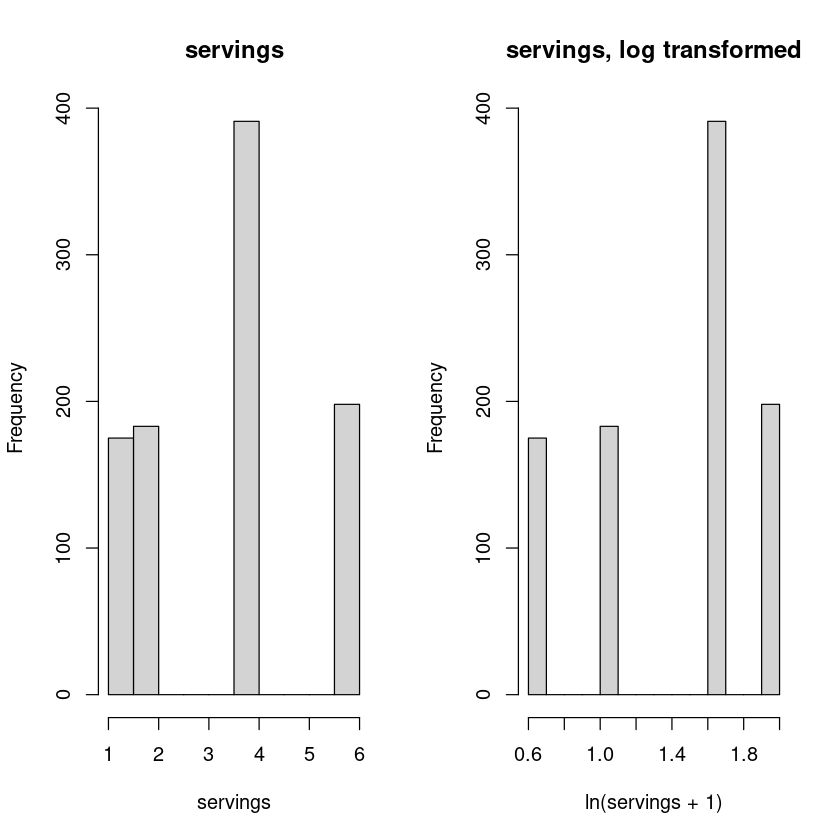

In [45]:
### HISTOGRAMS of numerical predictor variables

# names of numeric predictor variables
pvars <- c('calories', 'carbohydrate', 'sugar', 'protein', 'servings')

# histograms of numeric predictor variables
for(var in pvars){
   par(mfrow=c(1,2))	
   hist(dfr[,var], main=var, xlab=var) # untransformed
   hist(log1p(dfr[,var]), main=paste0(var, ", log transformed")
	  , xlab=paste0("ln(", var, " + 1)")) # log-transformed
}# end for() loop

#### Q-Q plots
For completeness, Q-Q plots for both log-transformed (ln(x + 1)) and untransformed variables are shown. These plots also indicate that log transformation brings the distributions of the four nutritional variables closer to normal.

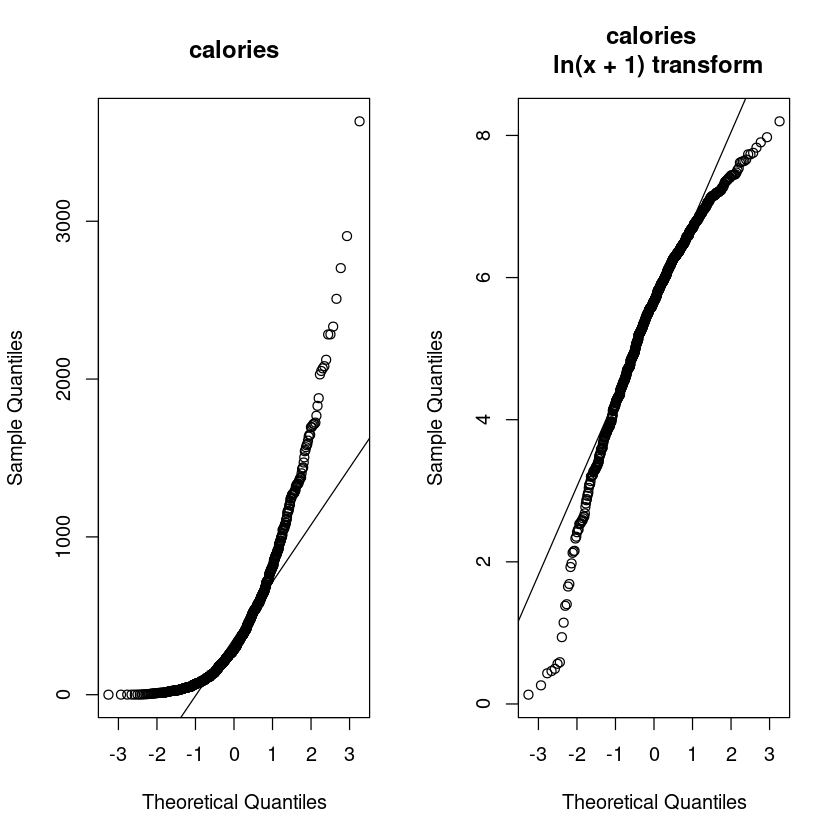

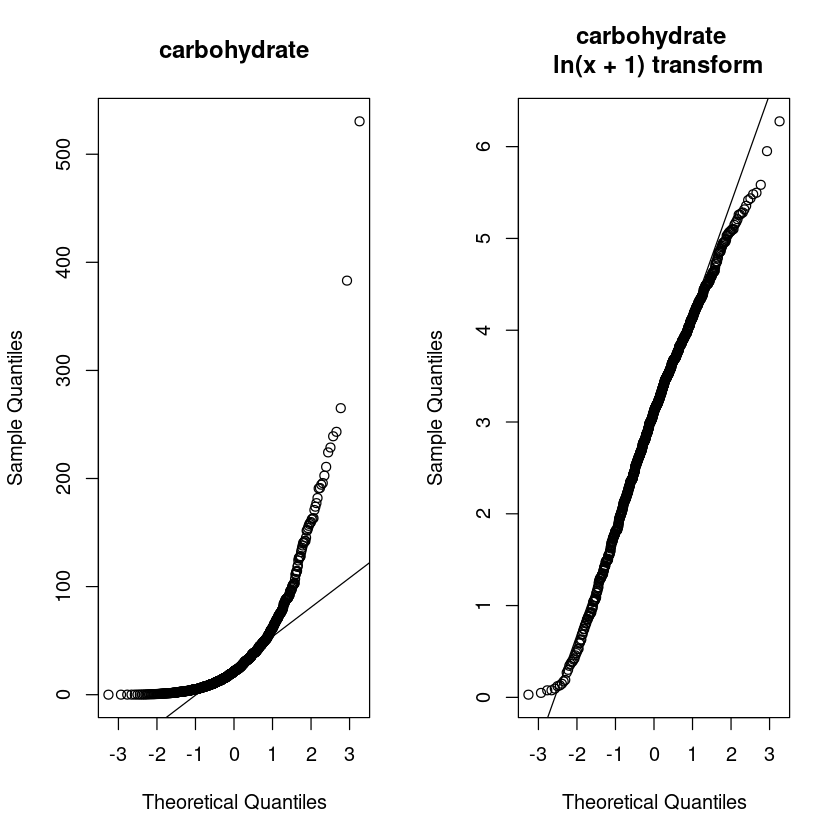

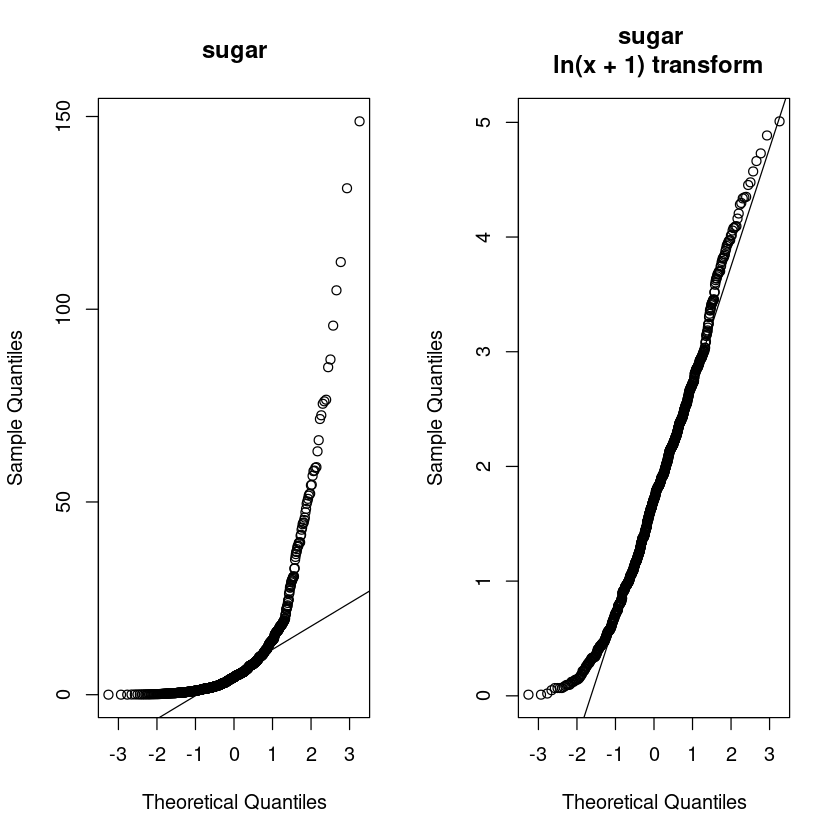

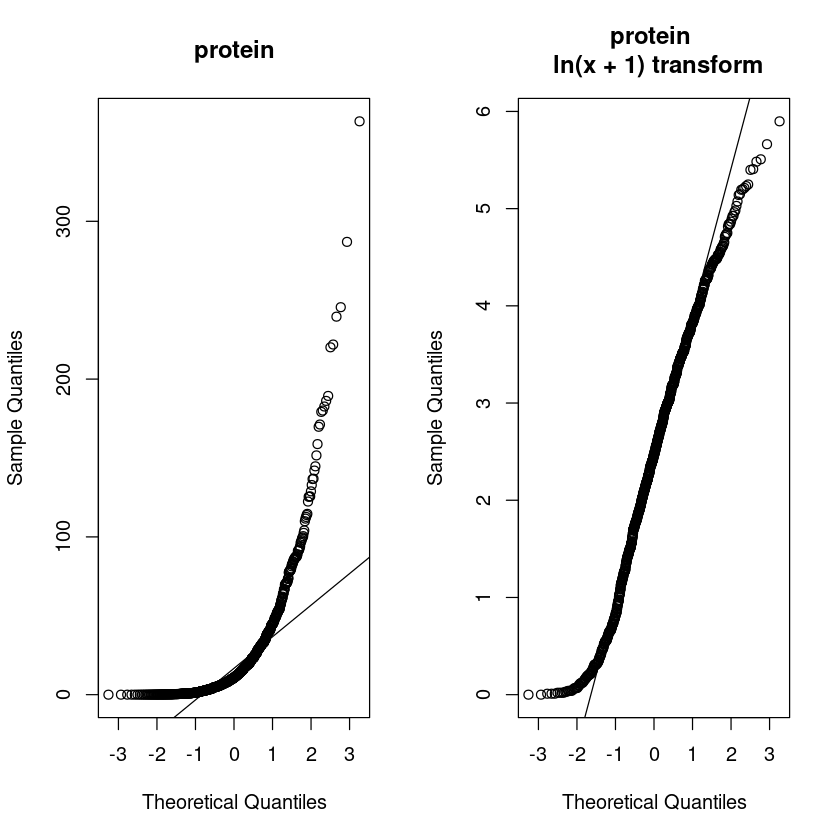

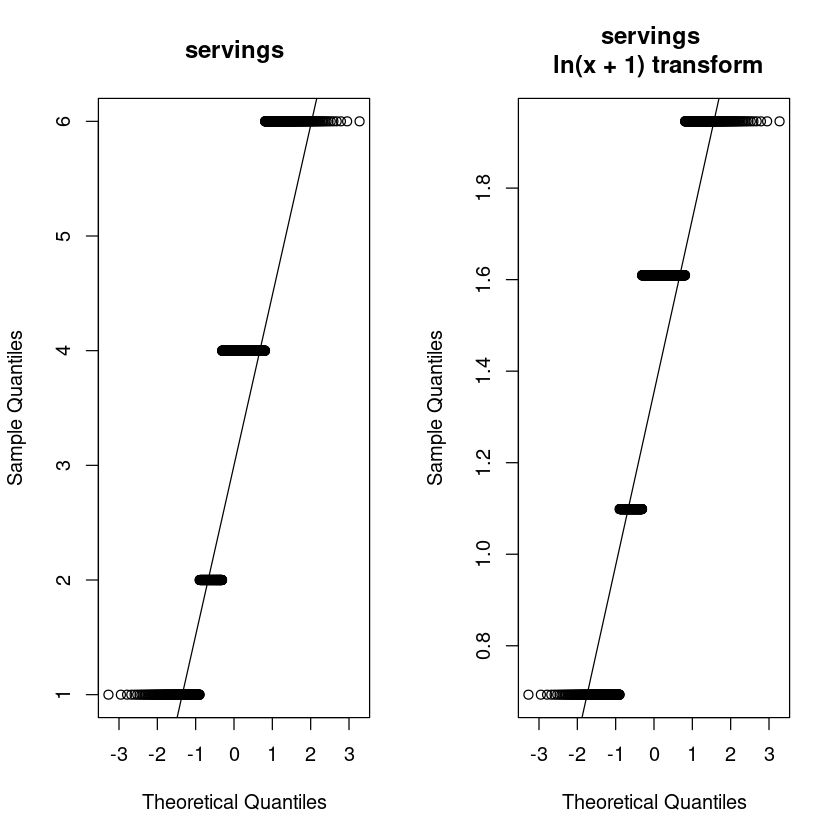

In [46]:
### Q-Q plots of numerical variables

pvars <- c('calories', 'carbohydrate', 'sugar', 'protein', 'servings')

# Q-Q plots of numeric predictor variables (minus protein)
for(var in pvars){
   par(mfrow=c(1,2))
   qqnorm(dfr[,var], main=var) # untransformed
   qqline(dfr[,var]) 
   qqnorm(log1p(dfr[,var]), main=paste(var, "\n ln(x + 1) transform"))  # log-transformed
   qqline(log1p(dfr[,var]))
}# end for() loop


#### Pairwise correlations
Pairwise Pearson correlations among `servings` and ln(x+1) transform of `calories`/`carbohydrate`/`sugar`/`protein` indicate weak correlations (|r|<sub>max</sub> = 0.19). This indicates little linear relationships between these variables and low risk of severe multicollinearity (an assumption of logistic regression).

Note the weak correlations between `sugar`--`carbohydrate` and between `calories` and the other three nutritional variables. This is suspicious, and is explored in the following, "Sanity check..." subsections.

maximum |r|: 0.19

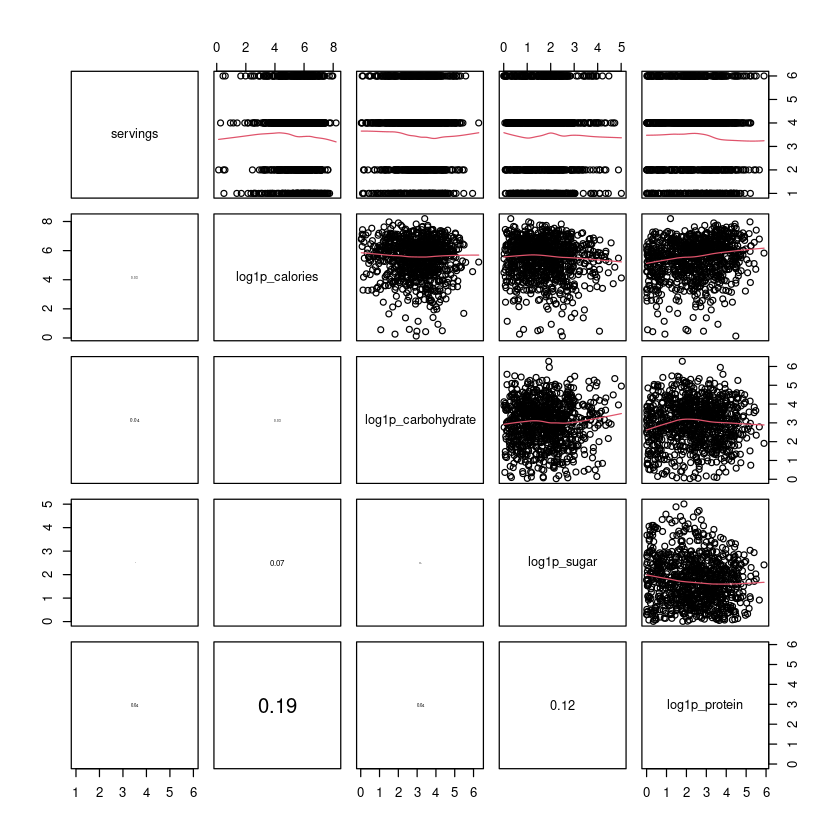

In [47]:
# the custom function panel.cor() below is from https://gettinggeneticsdone.blogspot.com/2011/07/scatterplot-matrices-in-r.html
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...) {
  usr <- par("usr"); on.exit(par(usr = usr))
  par(usr = c(0, 1, 0, 1))
  r <- suppressWarnings(cor(x, y, use = "pairwise.complete.obs"))
  r <- abs(r)
  txt <- formatC(r, format = "f", digits = digits)
  if (missing(cex.cor)) cex.cor <- 0.8/strwidth(txt)
  text(0.5, 0.5, paste0(prefix, txt), cex = cex.cor * r * 2)
}

# names of predictive numerical variables
pvars <- c('calories', 'carbohydrate', 'sugar', 'protein', 'servings')
pvarsl <- c('calories', 'carbohydrate', 'sugar', 'protein')


# isolate numerical predictive variables, log1p transform, and remove rows with NA values
dfpt <- dfr[dfr$missing == 0, pvars] %>% 
          mutate(across(pvarsl, log1p, .names="log1p_{col}")) %>%
          select(-pvarsl)

# plots of pairwise correlations
plot(dfpt, lower.panel = panel.cor, upper.panel = panel.smooth)


# check all pair-wise correlations, for thoroughness
CC <- c() # empty vector to hold correlation coefficients
counter <- 1
for(i in 1:ncol(dfpt)){
    for(j in 1:ncol(dfpt)){
		# Pearson correlation coefficient for variable pair i-j
		cc <- cor(dfpt[,i], dfpt[,j]) 

		# add correlation coefficient to vector, unless comparing a variable to itself
		CC <- if(i==j) {c(CC, NA)} else {c(CC, cc)}
		
		names(CC)[counter] <- paste(names(dfpt)[i], "___", names(dfpt)[j])

		counter <- counter + 1
	} # end inner for() loop
} # end outer for() loop

cat("maximum |r|:", round(max(abs(CC), na.rm=TRUE), 2))

#### Sanity check: sugar vs. carbs
Sugar content is a component of carbohydrate content. Therefore, it would be expected that for each recipe, sugar content is never greater than carbohydrate content. However, this is not the case for this dataset:
- 185 out of 947 recipes have sugar content _greater than_ carbohydrate content, as indicated by points below the red line in the scatterplot.
- This results in 185 negative values of non-sugar carbohydrates (as low as -80.26 g)--calculated by subtracting sugar (g) from carbohydrate (g), as indicated by values to the left of the blue line in the histogram. Negative values for carbohydrate mass are not physically possible.

[1] 185

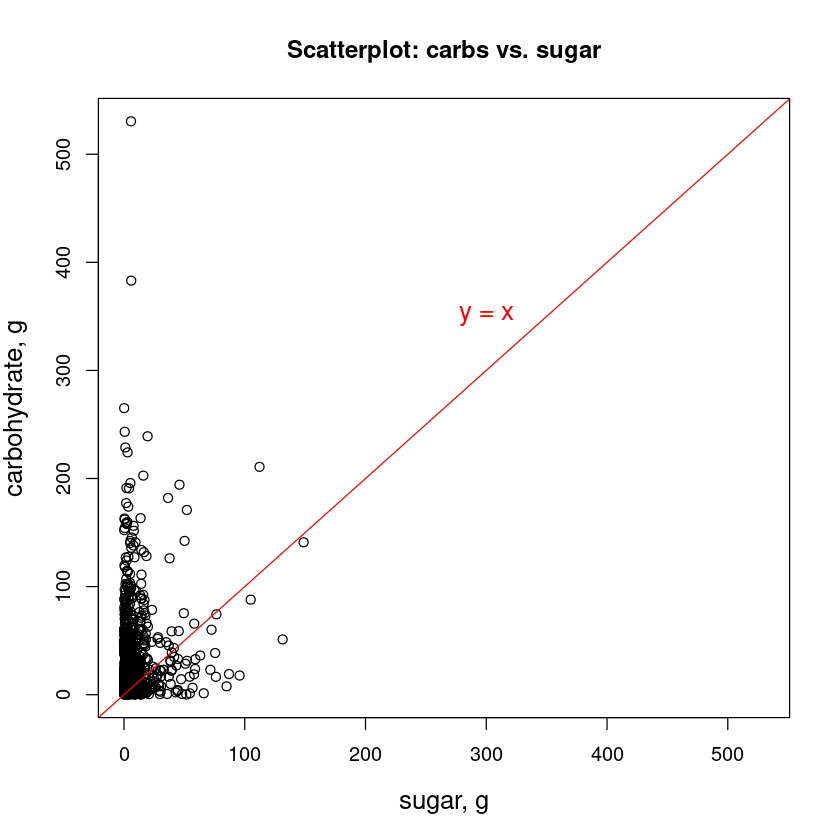

[1] -80.26 524.62

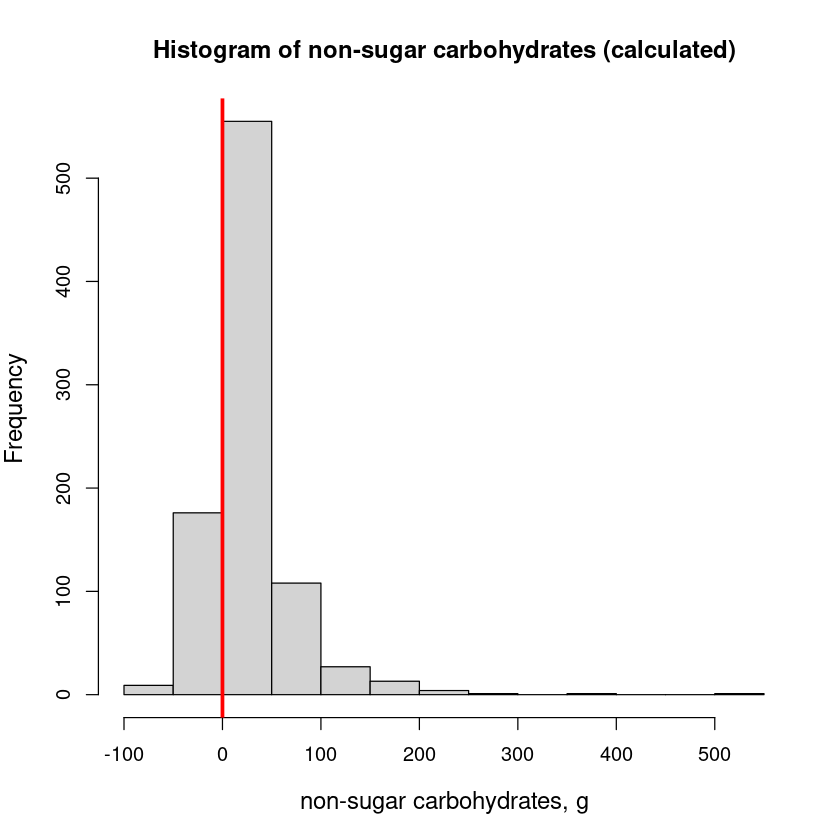

In [48]:
### carb content vs. sugar content
# NOTE: sugar (g) should never be greater than carb (g)

plot(x = dfr$sugar, y = dfr$carbohydrate, xlim=c(0,530), cex.lab=1.3
   , xlab="sugar, g", ylab="carbohydrate, g", main="Scatterplot: carbs vs. sugar")
abline(a=0, b=1, col="red") # plot line for y=x
text(x=300, y=350, labels="y = x", col="red", cex=1.3)

sum(dfr$sugar > dfr$carbohydrate, na.rm=TRUE) # number recipes with sugar > carb

hist(dfr$carbohydrate - dfr$sugar
   , xlab="non-sugar carbohydrates, g", cex.lab=1.2,
   , main="Histogram of non-sugar carbohydrates (calculated)")
abline(v = 0, col="red", lwd=3)

range(dfr$carbohydrate - dfr$sugar, na.rm=TRUE)

#### Sanity check: fat
Total calories can be calculated as follows:\
_calories = 4 * carbohydrate (g) + 4 * protein (g) + 9 * fat (g)_

Thus, fat content can be derived from the dataset by re-arranging the equation above as:\
_fat (g) = [calories - 4 * carbohydrate (g) - 4 * protein (g)] / 9_

This calculation results in 324 recipes with negative fat values (as low as -217 g fat), as indicated by the values to the left of the blue line in the histogram. Negative fat values are also not physically possible.

[1] 324

[1] -217.6622  389.7333

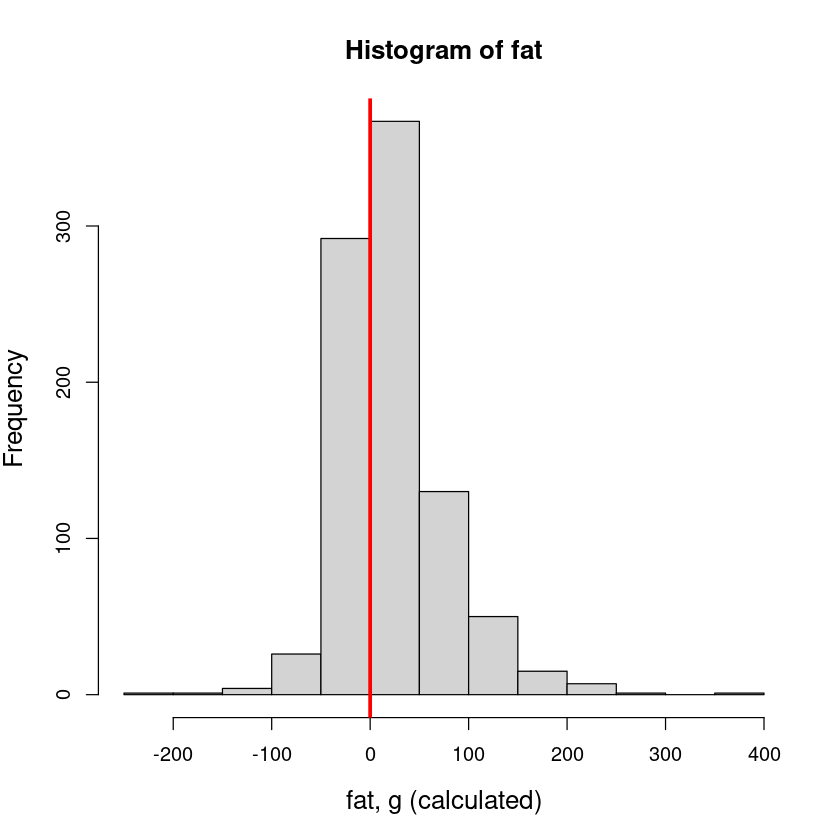

In [49]:
### calculated fat content

# calculate fat content in grams
fat <- (dfr$calories - 4*dfr$carbohydrate - 4*dfr$protein)/9

# histogram of calcualted fat values
hist(fat, xlab="fat, g (calculated)", cex.lab=1.3, cex.main=1.3)
abline(v = 0, col="red", lwd=3)

# number of negative fat values
sum(fat < 0, na.rm=TRUE)

# range of calculcated fat values
range(fat, na.rm=TRUE)

#### Servings vs. category/high_traffic
`servings` is the only numeric predictor variable that is still usable. But based on boxplots, it does not appear to have substantial variability with respect to the other remaining predictor variable (`category`) or to the target variable (`high_traffic`). Thus, I do not expect `servings` to be informative for modeling. 

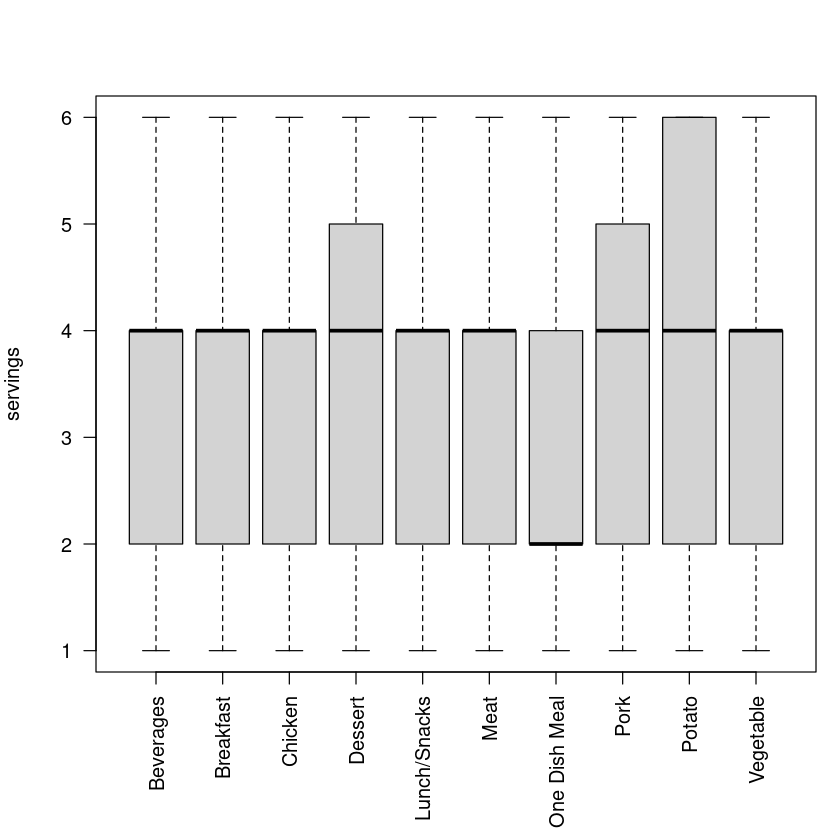

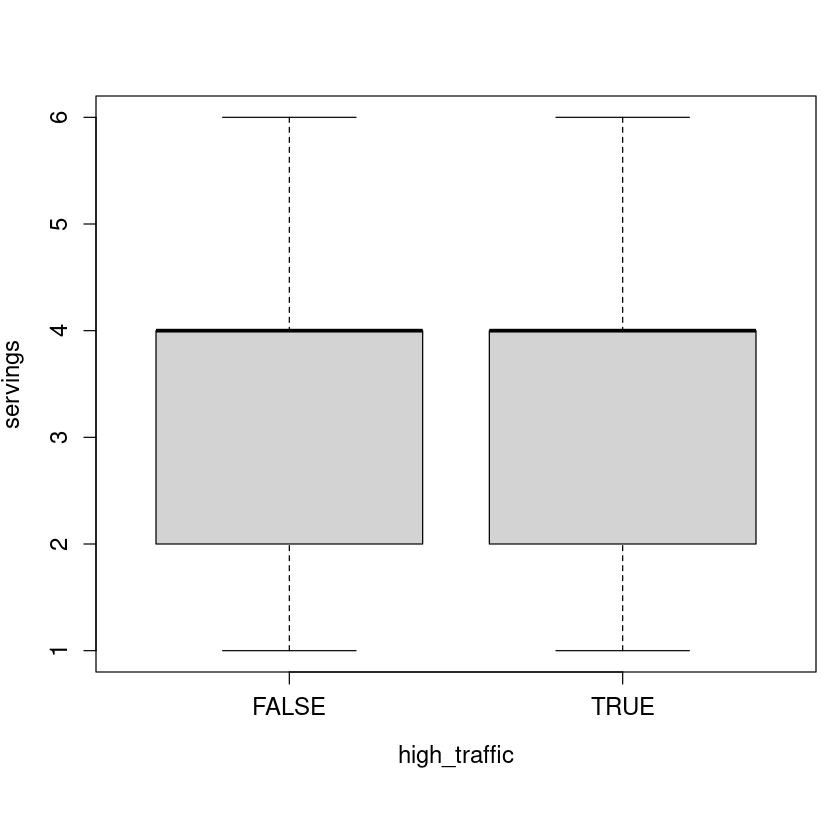

In [50]:
### Boxplots of $servings

# servings as a function of category
par(mar=c(7, 4, 4, 1))
boxplot(servings ~ category, data = dfr, las=2, xlab="")

# servings as a function of high_traffic
boxplot(servings ~ high_traffic, data = dfr, cex.axis=1.2, cex.lab=1.2)

#### Summary of numeric variables
- `calories`, `carbohydrate`, `sugar`, and `protein` contain data that are not physically possible. Therefore, these data are NOT reliable and will NOT be used for modeling, nor will their log transforms.
- This leaves `servings` and `catgory` as the only two usable predictor variables. `category` appears to be highly informative with respect to `high_traffic`, while `servings` does not.

### Revisiting $category
At this point, `category` appears to be the only informative variable with respect to the target variable `high_traffic`. Perhaps other informative variables can be derived from `category`.

One such category is a binary classification: meat (i.e., Chicken, Pork, and Meat categories) vs. everything else. But based on chi-squared analysis, this does not seem to be informative for predicting high traffic (p = 0.41, _X_ <sup>2</sup> = 0.68, df = 1).

So, `category` still appears to be the only informative variable.

In [51]:
# create a new category: meat or not meat
dfr$meat <- case_when(dfr$category %in% c("Pork", "Chicken", "Meat") ~ TRUE, TRUE ~ FALSE)

# check if the new catgory was created correctly --> YES
table(dfr$category, case_when(dfr$meat == 0 ~ "not meat",dfr$meat == 1 ~ "meat"))

# Chi-squared test: Does meat influence traffic level?
ct_meat_cat <- table(case_when(dfr$meat == 0 ~ "not meat",dfr$meat == 1 ~ "meat")
				  , case_when(dfr$high_traffic == 0 ~ "low tr.", TRUE ~ "high tr."))
ct_meat_cat
chisq.test(ct_meat_cat, correct=FALSE)


               
                meat not meat
  Beverages        0       92
  Breakfast        0      106
  Chicken        172        0
  Dessert          0       83
  Lunch/Snacks     0       89
  Meat            79        0
  One Dish Meal    0       71
  Pork            84        0
  Potato           0       88
  Vegetable        0       83

          
           high tr. low tr.
  meat          209     126
  not meat      365     247


	Pearson's Chi-squared test

data:  ct_meat_cat
X-squared = 0.68456, df = 1, p-value = 0.408


## Model Fitting & Validation
This is a classification problem (i.e., predict which recipes will generate high traffic). Therefore, I decided to use the following two types of models:
- Single-node decision tree (baseline model)
- Logistic regression (comparison models)

The goal of the project is to predict which recipes will be popular 80% of the time and to minimize the chance of showing unpopular recipes. This corresponds to maximizing _precision_ (i.e., TP / [TP + FP]) and minimizing _false discovery rate (FDR)_ (i.e., FP / [TP + FP]), where:
- TP = true positive
- FP = false positive

Since precision is the direct corrolary to false discovery rate (i.e., precision + FDR = 1), we need consider only precision.

**Thus, precision is the KPI and is the main performance metric by which the two models will be compared.**

### Split dataset: training & testing
The dataset was split into training and testing datasets using a 80/20 ratio, **_stratified by target variable `traffic_level`_**.

In [52]:
### create training and test sets, stratified by traffic level

prop <- 0.8 # proportion of samples to include in training set

idx <- split(1:nrow(dfr), dfr$high_traffic) # split row indices by traffic level

# sample indices for training set
set.seed(808)
idx2 <- unlist(lapply(idx, function(x) {sample(x, size = prop * length(x), replace = FALSE)}))
#str(idx2)

# split dataset into training and testing sets
train <- dfr[idx2,]
test <- dfr[-idx2,]					 

# verify that sample proportions are correct
nrow(train)/nrow(dfr) # 0.799 OK
nrow(test)/nrow(dfr) # 0.201 OK

# verify that proportion of high traffic samples is same btw train & test sets
mean(train$high_traffic) # 0.606 OK
mean(test$high_traffic) # 0.605 OK

[1] 0.7993664

[1] 0.2006336

[1] 0.6063408

[1] 0.6052632

### Baseline model: decision tree (single node)
Conceptually ans operationally, the model is simple: pick the top _n_ categories with the highest proportion of popular recipes, and use these categories to predict high traffic. It was chosen as the baseline model because of its simplicity and interpretability. 

#### Model training
In the case of this one-node decision tree, model training involved choosing a grouping of categories used to predict high traffic. I did this through the following steps:
1. I calculated the proportion of popular recipes in each cateogry of the training dataset.
2. I sorted categories by this proportion, from high to low.
3. I calculated the cumulative proportion of popular recipes for each grouping of top categories (i.e., category 1; category 1 + category 2; category 1 + category 2 + category 3; etc.). This value is a point estimate of precision (i.e., true positives / total positives).
4. For reach precision estimate, I calculated a one-sided, Wilson 95% confidence interval.
5. I compared the list of confidence interval lower bounds against the 0.8 precision threshold in order to choose a model with at least 95% chance of having precision $\geq$ 0.8. 

The trained model uses a grouping of the _top five_ categories--**Vegetable + Potato + Pork + Meat + One Dish Meal**--to predict popular recipes. Based on the training data, the predicted precision for this model is 0.87 (one-sided 95% Wilson CI: [0.83, 1.00]).

Note: the lower bound of the grouping of the _top six_ categories was only slightly less than 0.8. However, because model training tends to produce optimistic results, I decided to be conservative and strictly enforce the 0.8 threshold.

In [53]:
# Examining proprotion of high traffic recipes in each category of training set 

params <- train %>% group_by(category) %>%
          summarise(n_total = n(), n_high = sum(high_traffic, na.rm=TRUE)) %>%
          mutate(proportion_high = n_high / n_total) %>%
          arrange(desc(proportion_high)) %>%
          mutate(cumulative_n_total = cumsum(n_total)) %>%
          mutate(cumulative_n_high = cumsum(n_high)) %>%
          mutate(cumulative_precision = cumulative_n_high / cumulative_n_total) %>%
          relocate(cumulative_n_total, .after=n_total) %>%
          relocate(cumulative_n_high, .after=n_high) %>%
          mutate(LB_95CI = prop.test(cumulative_n_high, cumulative_n_total, correct=FALSE)$conf.int[1])

# getting Wilson confidence intervals
lb_95CI <- c()
ub_95CI <- c()
for(i in 1:nrow(params)){
	out <- prop.test(params$cumulative_n_high[i]
			       , params$cumulative_n_total[i]
				   , correct = FALSE
				   , alternative = "greater"
				   , conf.level = 0.95)
	lb_95CI <- c(lb_95CI, out$conf.int[1])
} # end for() loop


# adding CI lower bound to the table
params$LB_1sided_95CI_precision <- lb_95CI

# printing the table
params


category,n_total,cumulative_n_total,n_high,cumulative_n_high,proportion_high,cumulative_precision,LB_1sided_95CI_precision
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Vegetable,62,62,61,61,0.98387097,0.9838710,0.9308841
Potato,70,132,65,126,0.92857143,0.9545455,0.9145162
Pork,72,204,66,192,0.91666667,0.9411765,0.9078704
Meat,64,268,48,240,0.75000000,0.8955224,0.8607356
One Dish Meal,56,324,41,281,0.73214286,0.8672840,0.8332190
Lunch/Snacks,70,394,46,327,0.65714286,0.8299492,0.7965927
Dessert,64,458,41,368,0.64062500,0.8034934,0.7712085
Chicken,137,595,59,427,0.43065693,0.7176471,0.6863603
Breakfast,89,684,27,454,0.30337079,0.6637427,0.6334369


#### Model performance
I used the testing dataset to evaluate the one-node decision tree model's precision at predicting high traffic recipes. 

**The model's performance meets the KPI acceptance rule:** the lower bound of the _one-sided_ 95% Wilson CI of precision (0.82) exceeds the 0.8 threshold.

For comparing this model's performance against the comparison model, I calculated point estimates and interval estimates (i.e., _two-sided_ 95% Wilson CI's) of the following:
- Precision: the main business metric. This indicates the proportion of the time that the model's predictions of popular recipes are actually popular.
- Recall: an ancillary metric. This indicates the proportion of all popular recipes that the model is able to "find".
- Accuracy: another ancillary metric. This indicates how well the model sorts recipes into their correct class (i.e., popular vs not popular).

In [54]:
### model testing & performance

# set n: the first n-categories to include in high traffic prediciton group
n <- 5 

# select the first n categories
high_cats <- params$category[1:n]

# make predictions on the test dataset
test$pred_high_traffic <- if_else(test$category %in% high_cats, TRUE, FALSE)

# print confusion matrix
table(case_when(test$pred_high_traffic ~ "predict popular", TRUE ~ "predict not popular")
	, case_when(test$high_traffic ~ "popular", TRUE ~ "not popular"))

# count the number of true/false negatives/positives
tp <- sum(test$high_traffic & test$pred_high_traffic)
fp <- sum(!test$high_traffic & test$pred_high_traffic)
fn <- sum(test$high_traffic & !test$pred_high_traffic)
tn <- sum(!test$high_traffic & !test$pred_high_traffic)

# calculate point estimates of model metrics
prec <- tp/sum(tp, fp)
acc <- (tp + tn) / (tp + tn + fp + fn)
recall <- tp / (tp + fn)

# CI for KPI acceptance rule (only need lower bound of one-sided precision estimate)
ci_base_prec_1sided <- prop.test(tp, sum(tp, fp)
		                       , correct = FALSE
	                           , alternative = "greater"
		                       , conf.level = 0.95)

# CI for head-to-head comparisons of precision
ci_base_prec <- prop.test(tp, sum(tp, fp)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# CI for head-to-head comparisons of recall
ci_base_recall <- prop.test(tp, sum(tp, fn)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# CI for head-to-head comparisons of accuracy
ci_base_acc <- prop.test(sum(tp, tn), sum(tp, tn, fp, fn)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# create dataframe to hold results
model_metrics <- data.frame(metric = c("precision, one-sided"
				    	              , "precision"
								      , "recall"
									  , "accuracy")
						   , model=rep("baseline: dec. tree", 4)
						   , point_est = c(NA, prec, recall, acc)
						   , lb_95ci = c(ci_base_prec_1sided$conf.int[1]
					                   , ci_base_prec$conf.int[1]
						               , ci_base_recall$conf.int[1]
						               , ci_base_acc$conf.int[1])
						   , ub_95ci = c(NA
						               , ci_base_prec$conf.int[2]
					                   , ci_base_recall$conf.int[2]
						               , ci_base_acc$conf.int[2])
) # end data.frame()

# print results
model_metrics

                     
                      not popular popular
  predict not popular          66      43
  predict popular               9      72

metric,model,point_est,lb_95ci,ub_95ci
<chr>,<chr>,<dbl>,<dbl>,<dbl>
"precision, one-sided",baseline: dec. tree,NA,0.8184373,NA
precision,baseline: dec. tree,0.8888889,0.8021291,0.9404324
recall,baseline: dec. tree,0.6260870,0.5349264,0.7090962
accuracy,baseline: dec. tree,0.7263158,0.6589065,0.7847551


### Comparison model: logistic regression
There are only two legitimate predictor variables left in the dataset: `category` and `servings`. Based on EDA, `servings` does not appear to be informative with respect to `high_traffic`. This leaves `category` as the only predictor that is obviously informative.

However, the logistic regression model using just the `category` predictor is functionally equivalent to a one-node decision tree model based on groupings of categories, which is the baseline model. 

This is demonstrated below by comparing the proportions of high-traffic recipes in each category with the unique probability values predicted by the single-predictor logistic regression model. They are identical.

In [55]:
# logistic regression model with category as the lone predictor
mod1 <- glm(high_traffic ~ category, data = train, family = binomial)

# predict probabilities given the model
preds <- predict(mod1, newdata=train, type="response")

# compare proportions of high-traffic recipes in each category
#   to unique probabilities predicted by logistic regression
cbind(params$proportion_high, sort(unique(preds), decreasing = TRUE))

0.98387097,0.98387097
0.92857143,0.92857143
0.91666667,0.91666667
0.75000000,0.75000000
0.73214286,0.73214286
0.65714286,0.65714286
0.64062500,0.64062500
0.43065693,0.43065693
0.30337079,0.30337079
0.06849315,0.06849315


#### Model training
Therefore, in order to differentiate the comparison model from the baseline model, I am using both `category` and `servings` as predictors for the comparison model. 

The AIC of this two-predictor model is only 1.43 points greater than a model using `category` as the sole predictor. So, while AIC scores suggest that the single-predictor model will better fit the data, the two-predictor model is expected to fit the data only marginally worse.

In [56]:
### logistic regression: variable selection

# run logistic regression
mod_log_full <- glm(high_traffic ~ category + servings, data = train, family = binomial)

# compare AIC of different models
step(mod_log_full)

Start:  AIC=752.64
high_traffic ~ category + servings

           Df Deviance     AIC
- servings  1   731.21  751.21
<none>          730.64  752.64
- category  9  1010.91 1014.91

Step:  AIC=751.21
high_traffic ~ category

           Df Deviance     AIC
<none>          731.21  751.21
- category  9  1014.92 1016.92



Call:  glm(formula = high_traffic ~ category, family = binomial, data = train)

Coefficients:
          (Intercept)      categoryBreakfast        categoryChicken  
               -2.610                  1.779                  2.331  
      categoryDessert   categoryLunch/Snacks           categoryMeat  
                3.188                  3.261                  3.709  
categoryOne Dish Meal           categoryPork         categoryPotato  
                3.616                  5.008                  5.175  
    categoryVegetable  
                6.721  

Degrees of Freedom: 756 Total (i.e. Null);  747 Residual
Null Deviance:	    1015 
Residual Deviance: 731.2 	AIC: 751.2

I trained a logistic regression model on two predictors: `category` and `servings`. As expected, `servings` does not appear to be informative to the model (p = 0.45). Nonetheless, I will use `servings` to differentiate this model from the baseline model.

In [57]:
### logistic regression: model training

# optimized model
mod_log_opt <- glm(high_traffic ~ category + servings, data = train, family = binomial)

summary(mod_log_opt)


Call:
glm(formula = high_traffic ~ category + servings, family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8781  -0.8600   0.3835   0.8034   2.3529  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -2.74244    0.49694  -5.519 3.42e-08 ***
categoryBreakfast      1.78172    0.51771   3.442 0.000578 ***
categoryChicken        2.33175    0.49456   4.715 2.42e-06 ***
categoryDessert        3.18294    0.53172   5.986 2.15e-09 ***
categoryLunch/Snacks   3.25609    0.52749   6.173 6.71e-10 ***
categoryMeat           3.70512    0.54605   6.785 1.16e-11 ***
categoryOne Dish Meal  3.62941    0.55354   6.557 5.50e-11 ***
categoryPork           4.99198    0.63001   7.924 2.31e-15 ***
categoryPotato         5.15892    0.65611   7.863 3.75e-15 ***
categoryVegetable      6.71159    1.10940   6.050 1.45e-09 ***
servings               0.03916    0.05227   0.749 0.453798    
---
Signif. codes:  

Using the same criterion for model tuning that I used in the baseline model (i.e., lower bound of 95% Wilson CI of precision $\geq$ 0.80), I set the classification threshold of the comparison (logistic regression) model to 0.662. I did this by setting the initial threshold value low and then incrementally raising it, observing the confidence interval until the lower bound was just above 0.80.

At the chosen classification threshold, the lower bound of the one-sided 95% Wilson CI of precision is 0.82.

The boxplot shows that, at the chosen classification threshold, all recipes from the top five categories plus some recipes from the next two categories were classified as popular. This differs only slightly from what the decision tree predicted on the training set. 

The boxplot also shows that the variability of predicted probability values is greatest for the middle categories, suggesting that the `servings` variable has the greatest modulating effect on these middle categories in this model.

[1] 0.8118796

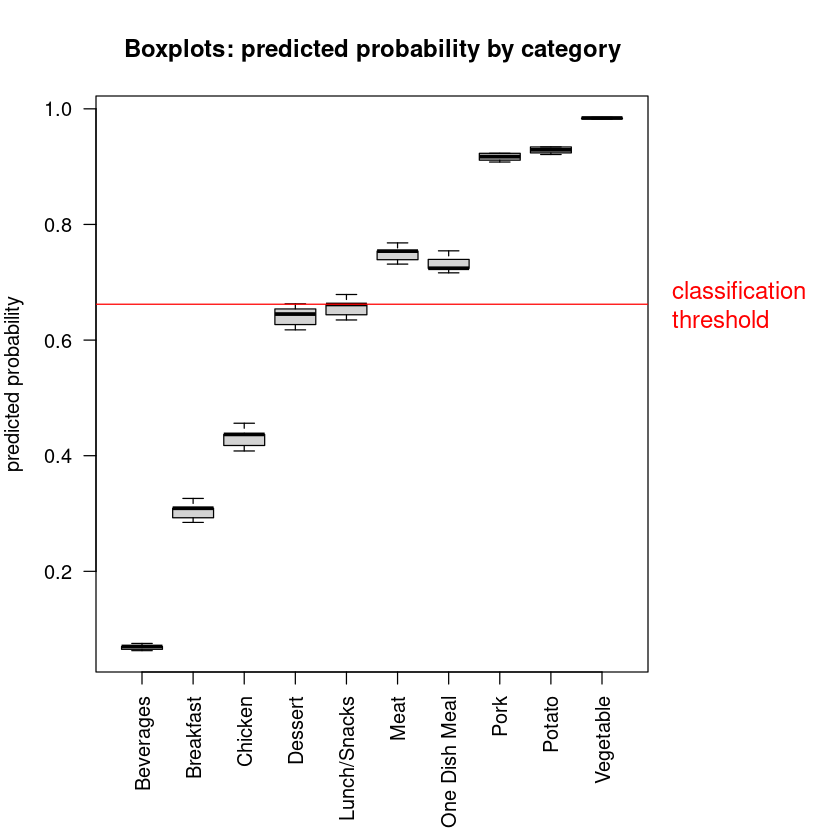

In [58]:
# probability predictions of the comparison model
preds_log <- predict.glm(mod_log_opt, newdata=train, type="response")

# set/adjust classification threshold
p_cutoff <- 0.662

# boxplot of probability predictions as a function of category
par(mar=c(7, 4, 4, 8))
boxplot(preds_log ~ train$category, las = 2, xlab=""
	  , ylab="predicted probability"
	  , main="Boxplots: predicted probability by category")
abline(h = p_cutoff, col = "red")
mtext("classification\nthreshold", side=4, line=1, at=p_cutoff, las=2, col="red", cex=1.2)

# predict high traffic recipes given the model
pred_high <- preds_log >= p_cutoff

# point estimate of model precision, based on training data
tp_train_log <- sum(pred_high & train$high_traffic)
fp_train_log <- sum(pred_high & !train$high_traffic)
prec <- tp_train_log / sum(tp_train_log, fp_train_log)

# get lower bound of confidence interval of the precision estimate
prop.test(tp_train_log
		, sum(tp_train_log, fp_train_log)
		, alternative="greater"
		, conf.level=0.95)$conf.int[1]

#### Model performance
I used the testing dataset to evaluate the two-predictor logistic regression model's precision at predicting high traffic recipes, gathering the same performance metrics as with the baseline model.

**The model's performance does NOT meet the KPI acceptance rule:** the lower bound of the 95% Wilson CI of precision (0.78) does NOT meet the 0.8 threshold, although it comes close. This failure is attributed to the classification threshold. If the classification threshold were set high enough, the model would have met the KPI acceptance cutoff.

In [59]:
# predict high traffic samples in the test set at the chosen classification threshold
test$pred_high_traffic_log <- predict(mod_log_opt, newdata=test, type="response") >= p_cutoff

# print confusion matrix
table(case_when(test$pred_high_traffic_log ~ "predict popular", TRUE ~ "predict not popular")
	, case_when(test$high_traffic ~ "popular", TRUE ~ "not popular"))

# calculate confusion matrix metrics
tp_log <- sum(test$high_traffic & test$pred_high_traffic_log)
fp_log <- sum(!test$high_traffic & test$pred_high_traffic_log)
fn_log <- sum(test$high_traffic & !test$pred_high_traffic_log)
tn_log <- sum(!test$high_traffic & !test$pred_high_traffic_log)

# calculate model evaluation metrics
prec_log <- tp_log/sum(tp_log, fp_log)
recall_log <- tp_log / (tp_log + fn_log)
acc_log <- (tp_log + tn_log) / (tp_log + tn_log + fp_log + fn_log)


# CI for KPI acceptance rule (only need lower bound of one-sided precision estimate)
ci_log_prec_1sided <- prop.test(tp_log, sum(tp_log, fp_log)
		                       , correct = FALSE
	                           , alternative = "greater"
		                       , conf.level = 0.95)

# CI for head-to-head comparisons of precision
ci_log_prec <- prop.test(tp_log, sum(tp_log, fp_log)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# CI for head-to-head comparisons of recall
ci_log_recall <- prop.test(tp_log, sum(tp_log, fn_log)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# CI for head-to-head comparisons of accuracy
ci_log_acc <- prop.test(sum(tp_log, tn_log), sum(tp_log, tn_log, fp_log, fn_log)
		       , correct = FALSE
			   , alternative = "two.sided"
			   , conf.level = 0.95)

# add metrics to dataframe
model_metrics2 <-  data.frame(metric = model_metrics$metric
                            , model = rep("comparison: log. regr.", 4)
                            , point_est  = c(NA, prec_log, recall_log, acc_log)
                            , lb_95ci = c(ci_log_prec_1sided$conf.int[1]
						                , ci_log_prec$conf.int[1]
						                , ci_log_recall$conf.int[1]
						                , ci_log_acc$conf.int[1])
                            , ub_95ci = c(NA
						                , ci_log_prec$conf.int[2]
						                , ci_log_recall$conf.int[2]
						                , ci_log_acc$conf.int[2])
) # end dataframe()

# print metrics
model_metrics2

# combine metrics into single table
model_metrics_complete <- rbind(model_metrics, model_metrics2)


                     
                      not popular popular
  predict not popular          61      36
  predict popular              14      79

metric,model,point_est,lb_95ci,ub_95ci
<chr>,<chr>,<dbl>,<dbl>,<dbl>
"precision, one-sided",comparison: log. regr.,NA,0.7786523,NA
precision,comparison: log. regr.,0.8494624,0.7630419,0.9081582
recall,comparison: log. regr.,0.6869565,0.5973205,0.7645061
accuracy,comparison: log. regr.,0.7368421,0.6699813,0.7943157


Since the comparison model came close to meeting the acceptance threshold, I want to at least be able to state a confidence level at which this model _does_ meet the threshold. As it turns out, the comparison model has **at least an 85% chance** of having precision that exceeds the 0.8 threshold.

In [60]:
# determine confidence level of meeting KPI acceptance threshold

# confidence levels, in increments of 5%
lvls <- seq(0.05, 0.95, 0.05)

# calculate LB of CI at each conf level
for(lvl in lvls){
   cat(lvl, " ",
   prop.test(tp_log, sum(tp_log, fp_log)
		                       , correct = FALSE
	                           , alternative = "greater"
		                       , conf.level = lvl)$conf.int[1], "\n")
}


0.05   0.9005142 
0.1   0.890894 
0.15   0.8838919 
0.2   0.878023 
0.25   0.872769 
0.3   0.8678761 
0.35   0.8631929 
0.4   0.8586156 
0.45   0.8540627 
0.5   0.8494624 
0.55   0.8447434 
0.6   0.8398271 
0.65   0.8346178 
0.7   0.8289881 
0.75   0.8227534 
0.8   0.8156187 
0.85   0.8070521 
0.9   0.795902 
0.95   0.7786523 


## Model evaluation: head-to-head comparison
Only the baseline, decision tree model strictly met the KPI acceptance threshold (i.e., lower bound of 95% CI of precision $\geq$ 0.80), although the comparison model came close.

The baseline model is also the easiest to understand and implement. The decision of whether to display a particular recipe is based solely on category, without any need to compute probabilities using a mathematical model.

Of the two models, the baseline model is expected to have slightly higher precision but slightly lower recall and accuracy, although none of these differences are significant. Recall can be improved by selecting more categories for inclusion, but this should be expected to come at the expense of precision.

See graphs below for comparisons of precision, recall, and accuracy.

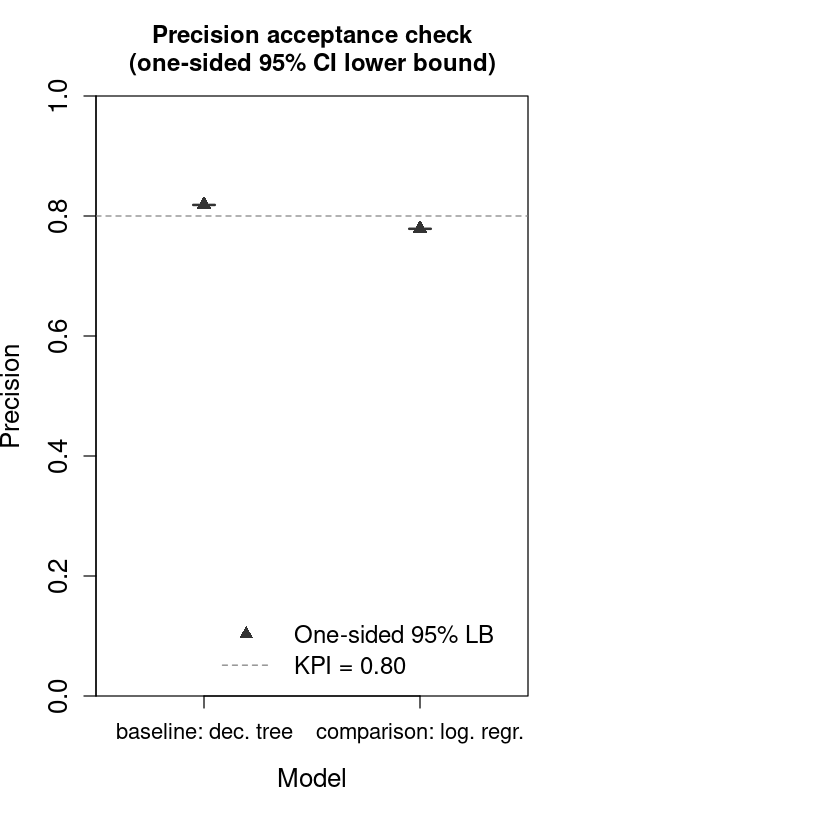

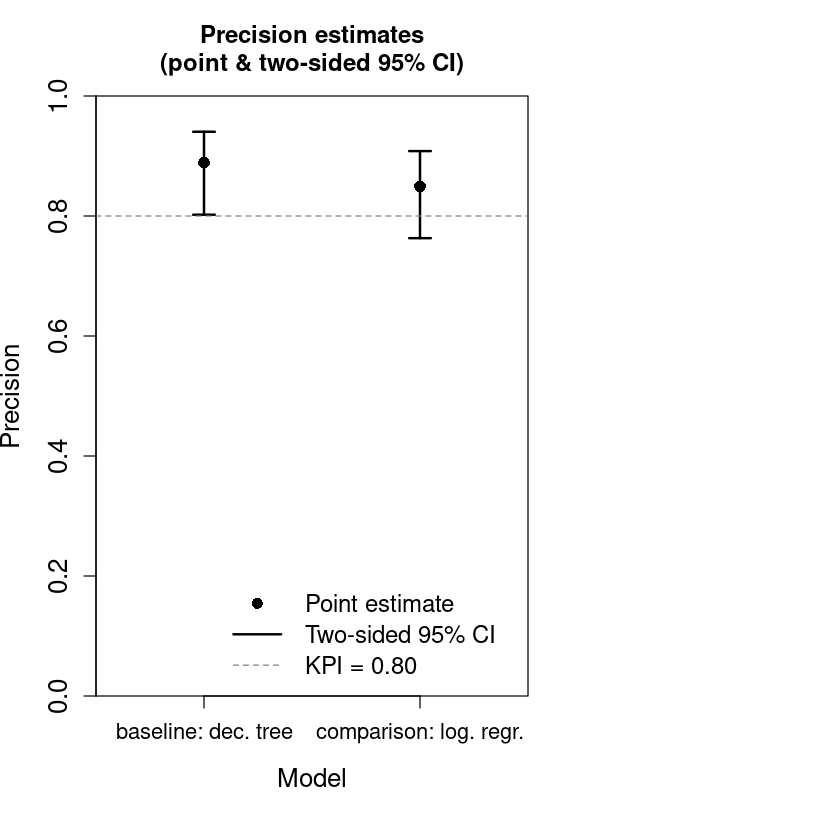

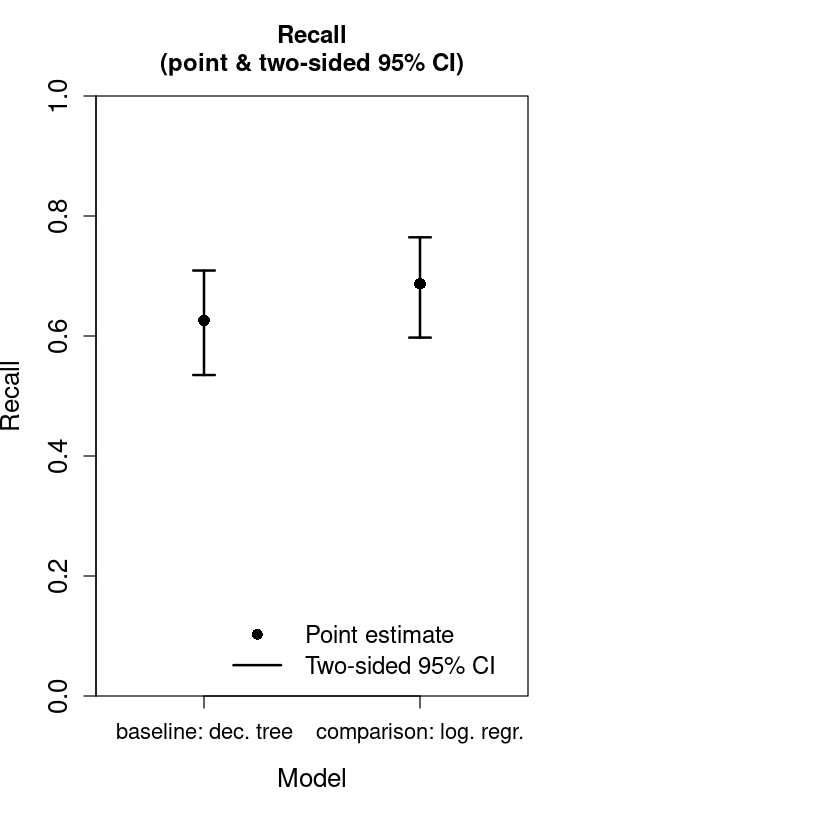

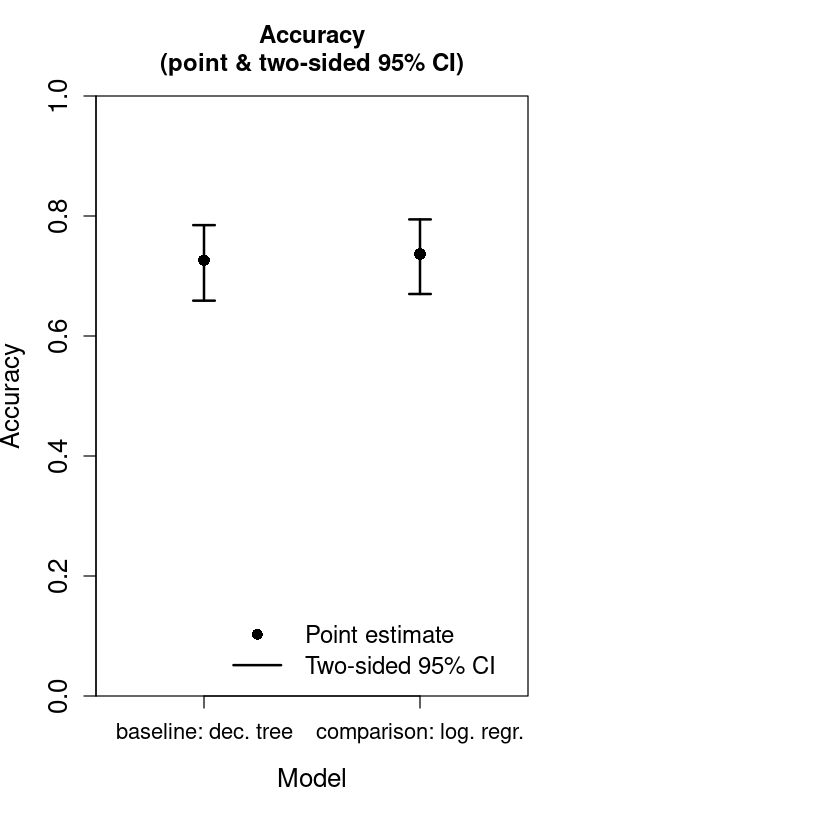

In [61]:
## Requires model_metrics_complete with columns:
##   model, metric ∈ {"precision, one-sided","precision","recall","accuracy"},
##   point_est, lb_95ci, ub_95ci (numeric; for one-sided only lb_95ci is used)

# Cast types once
for (v in c("point_est","lb_95ci","ub_95ci"))
  model_metrics_complete[[v]] <- as.numeric(model_metrics_complete[[v]])
model_metrics_complete$model <- factor(model_metrics_complete$model,
                                       levels = unique(model_metrics_complete$model))

# --- Plot 1: one-sided LB of precision only -----------------------------------
plot_precision_lb <- function(df, show_kpi = TRUE) {
  one <- subset(df, metric == "precision, one-sided")
  stopifnot(nrow(one) > 0)
  x <- seq_len(nrow(one))
  par(mar = c(6, 4, 4, 13))
  plot(NA, xlim = c(0.5, length(x)+0.5), ylim = c(0,1), xaxs = "i", yaxs = "i",
       xaxt = "n", xlab = "Model", ylab = "Precision",
       cex.lab = 1.3, cex.axis = 1.3,
       main = "Precision acceptance check\n(one-sided 95% CI lower bound)")
  axis(1, at = x, labels = one$model, las = 1, cex.axis = 1.1)
  points(x, one$lb_95ci, pch = 17, cex = 1.3, col = "gray20")
  segments(x-0.05, one$lb_95ci, x+0.05, one$lb_95ci, lwd = 2, col = "gray20")
  if (show_kpi) abline(h = 0.80, lty = 2, col = "gray50")
  legend("bottomright", bty = "n", cex = 1.2,
         legend = c("One-sided 95% LB", if (show_kpi) "KPI = 0.80" else NULL),
         pch = c(17, NA), lty = c(NA, 2), col = c("gray20","gray50"))
}

# --- Plot 2: two-sided precision (point + CI) ---------------------------------
plot_precision_2s <- function(df, show_kpi = FALSE) {
  two <- subset(df, metric == "precision")
  stopifnot(nrow(two) > 0)
  x <- seq_len(nrow(two))
  par(mar = c(6, 4, 4, 13))
  plot(NA, xlim = c(0.5, length(x)+0.5), ylim = c(0,1), xaxs = "i", yaxs = "i",
       xaxt = "n", xlab = "Model", ylab = "Precision",
       cex.lab = 1.3, cex.axis = 1.3,
       main = "Precision estimates\n(point & two-sided 95% CI)")
  axis(1, at = x, labels = two$model, las = 1, cex.axis = 1.1)
  segments(x, two$lb_95ci, x, two$ub_95ci, lwd = 2)
  segments(x-0.05, two$lb_95ci, x+0.05, two$lb_95ci, lwd = 2)
  segments(x-0.05, two$ub_95ci, x+0.05, two$ub_95ci, lwd = 2)
  points(x, two$point_est, pch = 16, cex = 1.3)
  if (show_kpi) abline(h = 0.80, lty = 2, col = "gray50")
  legend("bottomright", bty = "n", cex = 1.2,
         legend = c("Point estimate","Two-sided 95% CI",
                    if (show_kpi) "KPI = 0.80" else NULL),
         pch = c(16, NA, NA), lty = c(NA, 1, 2), lwd = c(NA, 2, 1),
         col = c("black","black","gray50"))
}

# --- Generic two-sided plotter for recall/accuracy ----------------------------
plot_metric <- function(df, metric_name, ylab, show_kpi = FALSE) {
  two <- subset(df, metric == metric_name)
  stopifnot(nrow(two) > 0)
  x <- seq_len(nrow(two))
  par(mar = c(6, 4, 4, 13))
  plot(NA, xlim = c(0.5, length(x)+0.5), ylim = c(0,1), xaxs = "i", yaxs = "i",
       xaxt = "n", xlab = "Model", ylab = ylab,
       cex.lab = 1.3, cex.axis = 1.3,
       main = paste0(tools::toTitleCase(metric_name), "\n(point & two-sided 95% CI)"))
  axis(1, at = x, labels = two$model, las = 1, cex.axis = 1.1)
  segments(x, two$lb_95ci, x, two$ub_95ci, lwd = 2)
  segments(x-0.05, two$lb_95ci, x+0.05, two$lb_95ci, lwd = 2)
  segments(x-0.05, two$ub_95ci, x+0.05, two$ub_95ci, lwd = 2)
  points(x, two$point_est, pch = 16, cex = 1.3)
  if (show_kpi) abline(h = 0.80, lty = 2, col = "gray50")
  legend("bottomright", bty = "n", cex = 1.2,
         legend = c("Point estimate","Two-sided 95% CI",
                    if (show_kpi) "KPI = 0.80" else NULL),
         pch = c(16, NA, NA), lty = c(NA, 1, 2), lwd = c(NA, 2, 1),
         col = c("black","black","gray50"))
}

# --- Draw the plots -----------------------------------------------------------
plot_precision_lb(model_metrics_complete, show_kpi = TRUE)   # acceptance check
plot_precision_2s(model_metrics_complete, show_kpi = TRUE)   # comparison view
plot_metric(model_metrics_complete, "recall",   "Recall",   show_kpi = FALSE)
plot_metric(model_metrics_complete, "accuracy", "Accuracy", show_kpi = FALSE)


## Business recommendations
Upon implementing our recommendations, the product team should monitor the percentage of popular recipes as both 30-day and 90-day moving averages. 

The 30-day moving average (30DMA) will be more responsive to changes but will also have more variability due to random noise. It can be used as an early signal of possible trend shifts. 

The 90-day moving average (90DMA) is more stable and is the preferred metric for making management decisions.

I recommend the follwing plan of action:
- Use the 1-node decision tree model. It is the easiest to understand and implement and performs similarly to the comparison model.
- To start, recipes should be chosen evenly across all five popular categories.
- If both 30DMA and 90DMA are above 80%, the model is performing well. Stay the course.
- If 30DMA dips below 80% but 90DMA is still above 80%, this indicates transient issues. Keep an eye on the metrics. 
- If both 30DMA and 90DMA are below 80%, we should consider using only recipes from the three most popular categories (i.e., Vegetable, Potato, Pork).
- If after making these changes, 30DMA and 90DMA remain below 80%, we should train a new model. In this case, we will need a greater variety of predictor variables to chose from, such as prep time, cost, and _accurate_ nutritional data (e.g., calories, protein, etc.).

### Initial values for business metric

Because date information is not included in the dataset provided to me, it is not possible to calculate the moving averages with certainty. However, if we assume that the recipes in the provided dataset are in chronological order at a rate of one recipe per day without any gaps in days, then a chart of moving averages would look like this:

In [62]:

percent_pop <- round(100 * sum(dfr$high_traffic)/length(dfr$high_traffic), 0)

cat(percent_pop, "% of recipes in the dataset generated high traffic")

61 % of recipes in the dataset generated high traffic

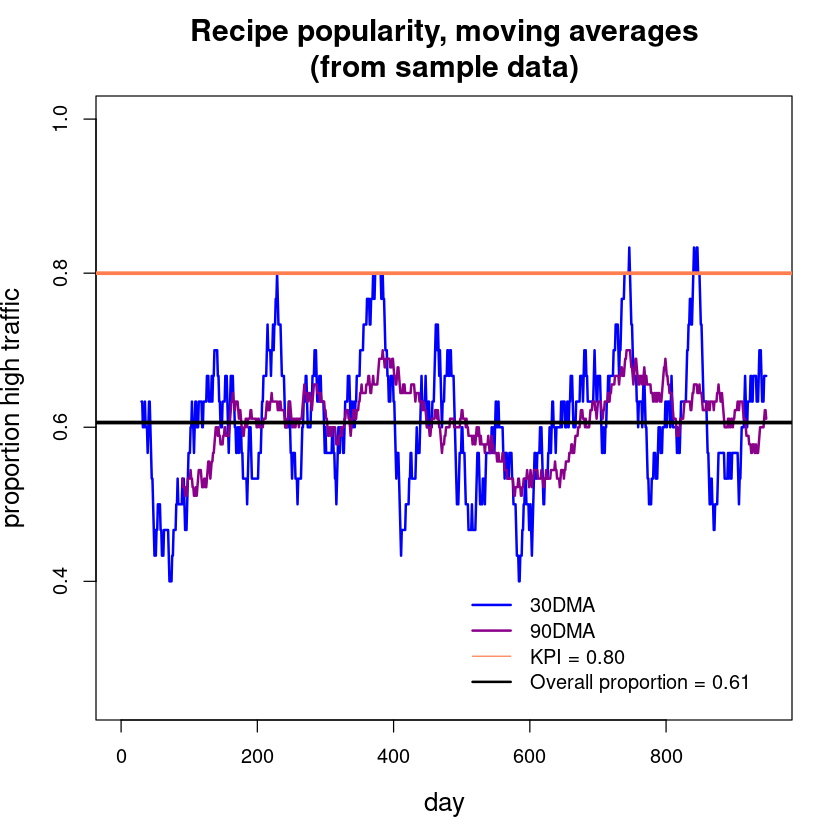

In [63]:
prop_high_orig <-sum(dfr$high_traffic)/length(dfr$high_traffic)

highs <- dfr %>% arrange(recipe) %>% select(high_traffic) %>% unlist()

# Simple trailing moving average (includes the current day).
# Returns a vector the same length as x; the first n-1 values are NA.
moving_avg <- function(x, n) {
  x <- as.numeric(x)                 # ensure numeric
  if (n <= 0L) stop("n must be positive")
  # Simple (unweighted) window of size n
  w <- rep(1 / n, n)
  # Trailing average: use sides = 1 (uses last n values up to each day)
  out <- stats::filter(x, filter = w, sides = 1)
  as.numeric(out)                    # convert from 'ts' to plain numeric
}

ma30 <- moving_avg(highs, 30)
ma90 <- moving_avg(highs, 90)

y_lim <- c(0.25, 1)

par(mar=c(5, 4, 4, 2))
plot(ma30, type = "l", 
   , main="Recipe popularity, moving averages\n(from sample data)"
   , xlab="day", ylab="proportion high traffic"
   , col="blue", cex.main=1.5, cex.lab=1.3, lwd=2
   , ylim=y_lim)

lines(ma90, col="darkmagenta", lwd=2)

thresh_col <-"coral"

abline(h = 0.8, col = thresh_col, lwd=3)          # KPI line
abline(h = prop_high_orig, col = "black", lwd = 3)  # overall proportion

# build labels
lab <- c("30DMA", "90DMA",
         sprintf("KPI = %.2f", 0.80),
         sprintf("Overall proportion = %.2f", prop_high_orig))

# one legend with line styles/colors
legend("bottomright", inset = 0.02,
       legend = lab,
       col = c("blue", "darkmagenta", thresh_col, "black"),
       lty = 1, lwd = c(2, 2, 1, 2), bty = "n")

...and if we apply the decision tree model, then the data might look something like this (same assumptions as above)..

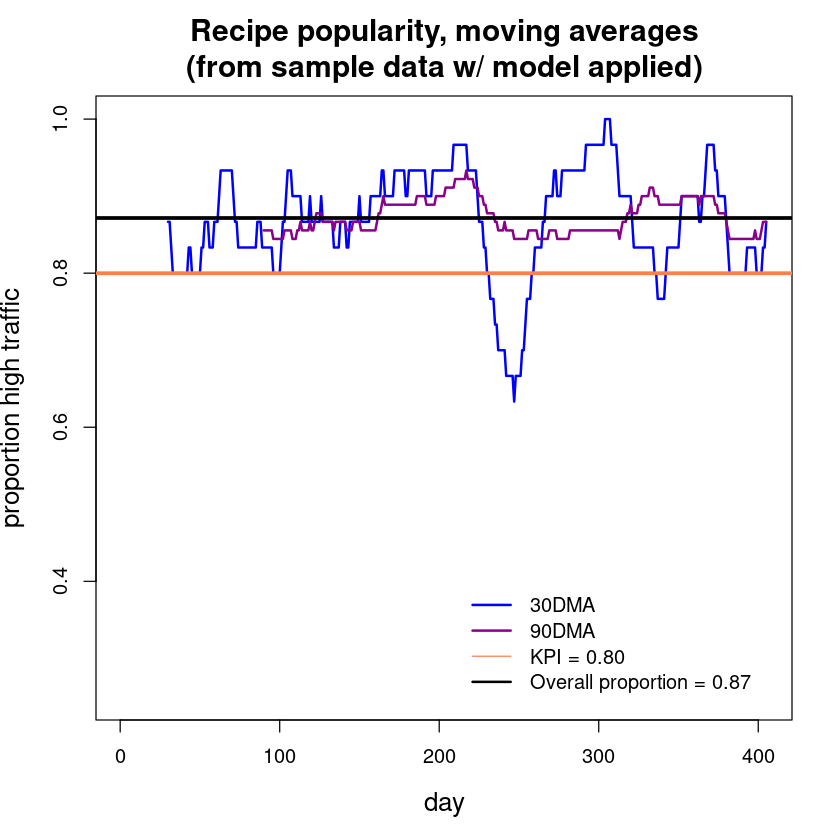

In [64]:
highs_filt <- dfr %>% arrange(recipe) %>% 
              filter(category %in% high_cats) %>% 
              select(high_traffic) %>% 
              unlist()

prop_high_filt <- sum(highs_filt)/length(highs_filt)


# Simple trailing moving average (includes the current day).
# Returns a vector the same length as x; the first n-1 values are NA.
moving_avg <- function(x, n) {
  x <- as.numeric(x)                 # ensure numeric
  if (n <= 0L) stop("n must be positive")
  # Simple (unweighted) window of size n
  w <- rep(1 / n, n)
  # Trailing average: use sides = 1 (uses last n values up to each day)
  out <- stats::filter(x, filter = w, sides = 1)
  as.numeric(out)                    # convert from 'ts' to plain numeric
}

ma30_filt <- moving_avg(highs_filt , 30)
ma90_filt <- moving_avg(highs_filt , 90)

par(mar=c(5, 4, 4, 2))
plot(ma30_filt, type = "l", 
   , main="Recipe popularity, moving averages\n(from sample data w/ model applied)"
   , xlab="day", ylab="proportion high traffic"
   , col="blue", cex.main=1.5, cex.lab=1.3, lwd=2
   , ylim=y_lim
) # end plot()

lines(ma90_filt, col="darkmagenta", lwd=2)

abline(h = 0.8, col = thresh_col, lwd=3)
abline(h=prop_high_filt, col="black", lwd=3)

# build labels
lab <- c("30DMA", "90DMA",
         sprintf("KPI = %.2f", 0.80),
         sprintf("Overall proportion = %.2f", prop_high_filt))

# one legend with line styles/colors
legend("bottomright", inset = 0.02,
       legend = lab,
       col = c("blue", "darkmagenta", thresh_col, "black"),
       lty = 1, lwd = c(2, 2, 1, 2), bty = "n")

## Final Summary
I was presented with a dataset of recipe information with the task of predicting which recipes will be popular 80% of the time. I determined this to be a classification problem. I determined the KPI to be model precision, with a minimum threshold of 80%.

I performed the following validation tasks:
- verified that `recipe` identifiers were unique, with no missing values.
- discovered that the data in `calories`, `carbohydrate`, `sugar`, and `protein`, when taken collectively, contain values that are not physically possible. Because of this, I did not use these variables in model development.
- cleaned up the `category` variable, consolidating two chicken categories into one and converting to a factor.
- cleaned up the `servings` variable and converted to numeric.
- converted `high_traffic`, the target variable, into a logical for ease of calculation.

After validation, only two candidate predictors remained: `category` appeared to be highly informative with respect to recipe popularity, while `servings` did not.

I used an 80/20 split to generate a training and testing dataset. I trained two models for predicting recipe popularity: 
- Baseline model: a simple, 1-node decision tree based on inclusing or exclusion in a subset of recipe categories.
- Comparison model: a logistic regression based on both cateogry and number of servings. `servings` was again demonstrated to be uninformative.

The criterion I used for model evaluation was whether the lower bound of the one-sided 95% Wilson confidence interval of precision was greater than or equal to 80% for the test dataset. I chose this criterion to ensure a 95% chance of meeting the KPI target. While both models had similar confidence intervals for precison, only the baseline model strictly met the KPI criterion. 

This failure of the comparison model is attributed to a low classification threshold rather than to the inclusion of the `servings` variable. Had I set the classification threshold a little higher, I suspect that the comparison model would have also met the KPI target. `servings` had a negligible affect on model characteristics, introducing a small amount of noise but otherwise not affecting predicitve ability much.

As would be expected, the model with slightly lower precision (i.e., comparison model) had slightly higher recall. In other words, because it was less picky, it was able to identify more of the popular recipes at the expense of also misidentifying more unpopular recipes as popular.

To improve the odds of displaying popular recipes at least 80% of the time, the product team should employ the 1-node decision tree model, displaying only recipes from the following five categories (ranked by popularity, high to low): Vegetable, Potato, Pork, Meat, and One Dish Meal. To start, the mix across categories should be even (perhaps on a rotation). We should monitor the 30- and 90-day moving averages of the proportion of popular recipes displayed. If both moving averages dip below 80%, the product team should consider removing the less popular categories from among the list of five. 

If this strategy also fails to meet the KPI, or if more recipe variety is desired, then we will need a greater variety of predictor variables, such as _accurate_ nutritional data, prep time, and cost. This should allow the data science team to better identify popular recipes, especially in the less popular categories, thus meeting desired precision while improving recall.